# Bachelor Thesis - Data Analysis
### Sidorenko Elena 
#### 2102516


## IMPORTING LIBRARIES

In [1]:
!pip install umap-learn
!pip install scikit-learn
!pip install matplotlib

In [2]:
import matplotlib
import numpy as np 
import pandas as pd 
import datetime as dt
import seaborn as sns   
import umap.umap_ as umap
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## DATA CLEANING & PREPARATION

In [3]:
data = pd.read_csv('raw_data_sample3000.csv')
data = data.pivot_table(index='User ID', columns='Event Name', values='Event Count')

In [4]:
# Add Posts data to the dataset
posts_data = pd.read_csv('Posts.csv')
data       = data.merge(posts_data[['User ID', 'Posts']], on='User ID', how='left')

In [5]:
# Check data typers
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 191 columns):
 #    Column                                    Dtype  
---   ------                                    -----  
 0    User ID                                   object 
 1    account_deletion_successful               float64
 2    account_i_d_copy_tap                      float64
 3    account_infos_tile_tap                    float64
 4    anonymous_signup                          float64
 5    app_bar_profile_tap                       float64
 6    app_bar_social_conn_tap                   float64
 7    app_clear_data                            float64
 8    app_exception                             float64
 9    app_infos_settings_tile_tap               float64
 10   app_remove                                float64
 11   app_update                                float64
 12   biography_change                          float64
 13   brands_feed_scroll_end                    floa

In [6]:
# Check how many NULL values there are
column_counts  = data.count()
column_names   = data.columns.tolist()
total_rows     = data.shape[0]

for column in column_names:
    null_count = column_counts[column]
    print(f"{column:<30} {null_count} null")
    
print(f"\nRangeIndex: {total_rows} entries, 0 to {total_rows-1}")
print(f"Data columns (total {len(column_names)} columns):")

User ID                        3000 null
account_deletion_successful    61 null
account_i_d_copy_tap           20 null
account_infos_tile_tap         115 null
anonymous_signup               290 null
app_bar_profile_tap            1320 null
app_bar_social_conn_tap        431 null
app_clear_data                 1 null
app_exception                  27 null
app_infos_settings_tile_tap    32 null
app_remove                     156 null
app_update                     1816 null
biography_change               206 null
brands_feed_scroll_end         650 null
brands_feed_scroll_start       655 null
camera_capture_btn_tap         98 null
camera_close                   329 null
camera_gallery_btn_tap         368 null
camera_media_confirm           355 null
camera_media_discard           209 null
camera_recording_start         19 null
camera_recording_stop          19 null
camera_sticker_btn_tap         101 null
camera_switch                  19 null
campaign_collaboration_created 1 null
campaign_

In [7]:
# Fill NaN values with 0
data.replace(' ', 0, inplace=True)
data.fillna (0, inplace=True)

In [8]:
# Remove unnecessary columns and merge columns with the same attributes
data                        = data[data['legal_disagree'] == 0]
data['follow']              = data      ['story_follow_btn_tap']  + data['user_follow'] 
data['unfollow']            = data      ['story_unfollow_btn_tap']+ data['user_unfollow']  
data                        = data.drop(['story_follow_btn_tap', 'screen_view','story_unfollow_btn_tap', 'user_follow', 
                                         'user_unfollow','user_engagement','screen_view', 'user_engagement',
                                         'legal_disagree','legal_agree','os_update'], axis=1)

In [9]:
# Replace User ID with numbers 1-3000
data['User ID'] = [i+1 for i, _ in enumerate(data['User ID'])]

In [10]:
# Find columns that do not have any data
zero_columns = data.columns[(data == 0).all()]
zero_columns.tolist()
zero_columns
# There are no empty columns

Index([], dtype='object')

In [11]:
# Save cleaned data set
data.to_csv('Cleaned_Data.csv', index=False)

## Discriptive Statistics

In [12]:
# Add a column "SUM" that summs all the other columns

# Get all column names except "User ID"
columns_to_sum = data.columns[data.columns != 'User ID']  
data['SUM']    = data[columns_to_sum].sum(axis=1) 

In [13]:
# Get Min, Max, Mean, Standard Deviation of the sum of all in-app events
data.describe()

,User ID,account_deletion_successful,account_i_d_copy_tap,account_infos_tile_tap,anonymous_signup,app_bar_profile_tap,app_bar_social_conn_tap,app_clear_data,app_exception,app_infos_settings_tile_tap,...,tik_tok_link_submit_btn_tap,tik_tok_open_paste_link_btn_tap,tik_tok_social_change,tutorial_settings_tile_tap,username_change,welcome_page_open,Posts,follow,unfollow,SUM
count,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,...,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000,2990.000000
mean,1495.500000,0.019398,0.009365,0.053512,0.097659,2.582943,0.266555,0.000334,0.011706,0.013378,...,0.000669,0.001003,0.060870,0.028763,0.034114,0.184950,0.514381,0.068896,0.012709,97.048495
std,863.282978,0.137942,0.143718,0.330980,0.317592,9.053961,0.965195,0.018288,0.147001,0.145715,...,0.036576,0.054864,0.310905,0.211359,0.204107,0.408476,4.667925,0.612627,0.161041,350.006998
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,748.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,1495.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000
75%,2242.750000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.750000
max,2990.000000,1.000000,5.000000,8.000000,6.000000,179.000000,15.000000,1.000000,5.000000,4.000000,...,2.000000,3.000000,7.000000,3.000000,4.000000,4.000000,120.000000,17.000000,4.000000,7408.000000


In [14]:
data = data[data['SUM'] != 0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2940 entries, 0 to 2999
Columns: 185 entries, User ID to SUM
dtypes: float64(183), int64(2)
memory usage: 4.2 MB


In [15]:
# Checking again Min, Max, Mean, Standard Deviation of the sum of all in-app events
print("Minimum: ", data['SUM'].min())
print("Maximum: ", data['SUM'].max())
print("Mean: ", data['SUM'].mean())
print("Standard Deviation: ", data['SUM'].std())

Minimum:  1.0
Maximum:  7408.0
Mean:  98.69897959183673
Standard Deviation:  352.74079374657356


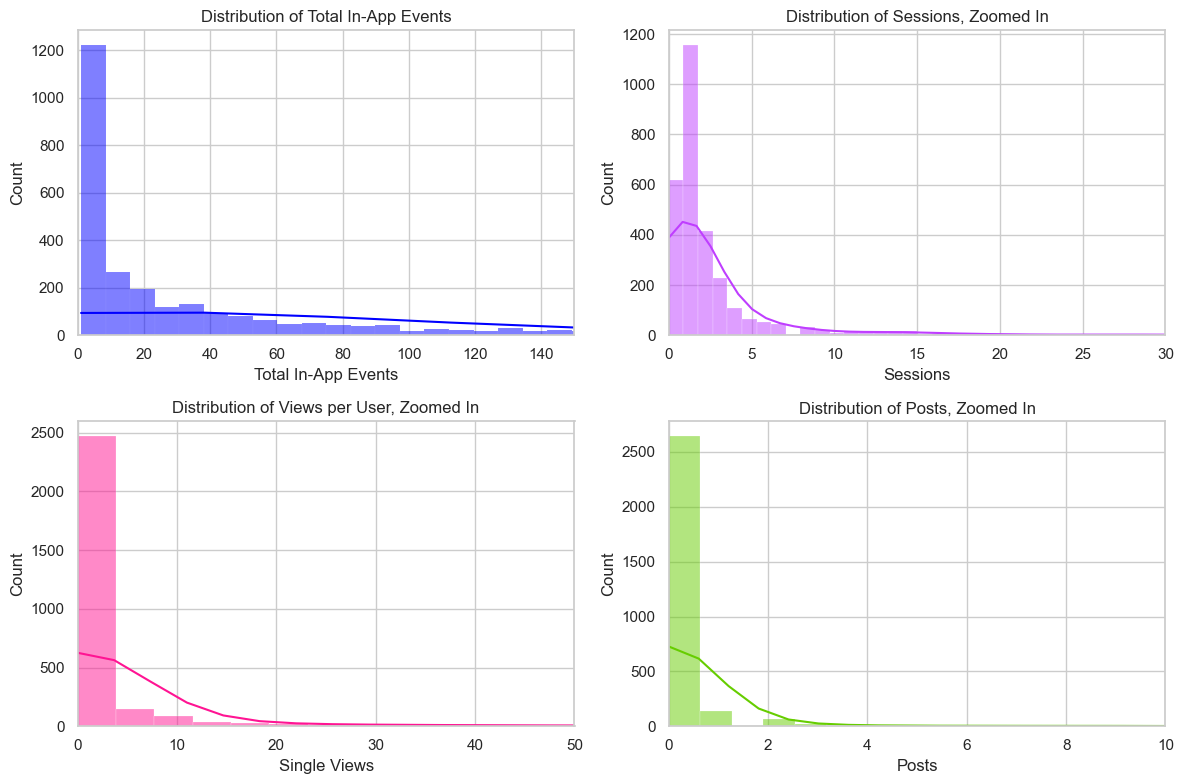

In [16]:
# Distribution of KPIs. Zooming in by limiting x-axis by 5, 30, and 50 to better visualize the data.

sns.set(font_scale=1, style='whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Distribution of Total In-App Events
sns.histplot(data['SUM'], color='#0000FF', kde=True, bins=1000, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Total In-App Events')
axes[0, 0].set_xlim(0, 150)
axes[0, 0].set_xlabel('Total In-App Events')

# Distribution of Sessions
sns.histplot(data['session_start'], color='#BF3EFF', kde=True, bins=189, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Sessions, Zoomed In')
axes[0, 1].set_xlim(0, 30)
axes[0, 1].set_xlabel('Sessions')

# Distribution of Views per User
sns.histplot(data['discover_story_detail_open'], color='#FF1493', kde=True, bins=189, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Views per User, Zoomed In')
axes[1, 0].set_xlim(0, 50)
axes[1, 0].set_xlabel('Single Views')

# Distribution of Posts
sns.histplot(data['Posts'], color='#66CD00', kde=True, bins=189, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Posts, Zoomed In')
axes[1, 1].set_xlim(0, 10)

plt.tight_layout()
plt.show()

In [17]:
# Drop column SUM
data = data.drop(['SUM'], axis=1)

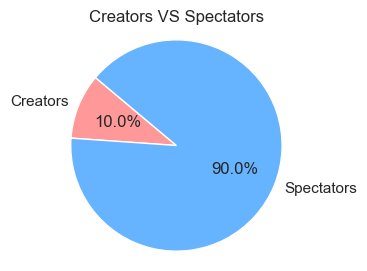

In [79]:
import matplotlib.pyplot as plt

# Data
labels = ['Creators', 'Spectators']
sizes = [294, 2646]
colors = ['#ff9999', '#66b3ff']  # Vibrant colors

# Create a pie chart with a smaller size
plt.figure(figsize=(3, 3))  # Adjust the figsize to make it two times smaller

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Creators VS Spectators')

# Display the chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [18]:
# Save the data again
data.to_csv('Cleaned_Data.csv', index=False)

In [19]:
data.describe()

,User ID,account_deletion_successful,account_i_d_copy_tap,account_infos_tile_tap,anonymous_signup,app_bar_profile_tap,app_bar_social_conn_tap,app_clear_data,app_exception,app_infos_settings_tile_tap,...,tik_tok_link_submission_successful,tik_tok_link_submit_btn_tap,tik_tok_open_paste_link_btn_tap,tik_tok_social_change,tutorial_settings_tile_tap,username_change,welcome_page_open,Posts,follow,unfollow
count,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000,...,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000,2940.000000
mean,1497.935714,0.019728,0.009524,0.054422,0.099320,2.626871,0.271088,0.000340,0.011905,0.013605,...,0.000680,0.000680,0.001020,0.061905,0.029252,0.034694,0.188095,0.523129,0.070068,0.012925
std,861.692689,0.139087,0.144931,0.333709,0.320024,9.124329,0.972739,0.018443,0.148238,0.146939,...,0.036886,0.036886,0.055328,0.313436,0.213116,0.205787,0.411217,4.706978,0.617750,0.162396
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,753.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1499.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2242.250000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2990.000000,1.000000,5.000000,8.000000,6.000000,179.000000,15.000000,1.000000,5.000000,4.000000,...,2.000000,2.000000,3.000000,7.000000,3.000000,4.000000,4.000000,120.000000,17.000000,4.000000


In [20]:
# Create an empty list to store the filtered rows
creators   = []
spectators = []

# Iterate through each row in the dataset
for index, row in data.iterrows():
    # Check if the "Posts" value is greater than or equal to 1
    if row['Posts'] >= 1:
        # Add the row to the filtered_rows list
        creators.append(row)
    else: 
        spectators.append(row)
            

# Create a new DataFrame from the filtered_rows list
creators   = pd.DataFrame(creators)
spectators = pd.DataFrame(spectators)

# Get general statistics for new datasets
creators.describe()

,User ID,account_deletion_successful,account_i_d_copy_tap,account_infos_tile_tap,anonymous_signup,app_bar_profile_tap,app_bar_social_conn_tap,app_clear_data,app_exception,app_infos_settings_tile_tap,...,tik_tok_link_submission_successful,tik_tok_link_submit_btn_tap,tik_tok_open_paste_link_btn_tap,tik_tok_social_change,tutorial_settings_tile_tap,username_change,welcome_page_open,Posts,follow,unfollow
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,...,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,1535.367347,0.013605,0.030612,0.136054,0.017007,17.894558,1.418367,0.003401,0.034014,0.061224,...,0.006803,0.006803,0.010204,0.353741,0.200680,0.125850,0.064626,5.231293,0.414966,0.081633
std,854.219494,0.116044,0.191317,0.543525,0.129517,22.935116,2.269805,0.058321,0.199486,0.354868,...,0.116642,0.116642,0.174964,0.703989,0.557787,0.361753,0.259772,14.054292,1.406196,0.396404
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,811.750000,0.000000,0.000000,0.000000,0.000000,4.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1608.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
75%,2267.750000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
max,2987.000000,1.000000,2.000000,5.000000,1.000000,179.000000,15.000000,1.000000,2.000000,4.000000,...,2.000000,2.000000,3.000000,7.000000,3.000000,2.000000,2.000000,120.000000,14.000000,4.000000


In [21]:
spectators.describe()

,User ID,account_deletion_successful,account_i_d_copy_tap,account_infos_tile_tap,anonymous_signup,app_bar_profile_tap,app_bar_social_conn_tap,app_clear_data,app_exception,app_infos_settings_tile_tap,...,tik_tok_link_submission_successful,tik_tok_link_submit_btn_tap,tik_tok_open_paste_link_btn_tap,tik_tok_social_change,tutorial_settings_tile_tap,username_change,welcome_page_open,Posts,follow,unfollow
count,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.000000,2646.0,2646.000000,2646.000000,...,2646.0,2646.0,2646.0,2646.000000,2646.000000,2646.000000,2646.000000,2646.0,2646.000000,2646.000000
mean,1493.776644,0.020408,0.007181,0.045351,0.108466,0.930461,0.143613,0.0,0.009448,0.008314,...,0.0,0.0,0.0,0.029478,0.010204,0.024565,0.201814,0.0,0.031746,0.005291
std,862.578968,0.141419,0.138673,0.300320,0.333323,2.334196,0.564021,0.0,0.141239,0.098796,...,0.0,0.0,0.0,0.209149,0.111230,0.177574,0.422537,0.0,0.436229,0.106368
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,751.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,1486.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,2238.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
max,2990.000000,1.000000,5.000000,8.000000,6.000000,38.000000,12.000000,0.0,5.000000,2.000000,...,0.0,0.0,0.0,4.000000,3.000000,4.000000,4.000000,0.0,17.000000,4.000000


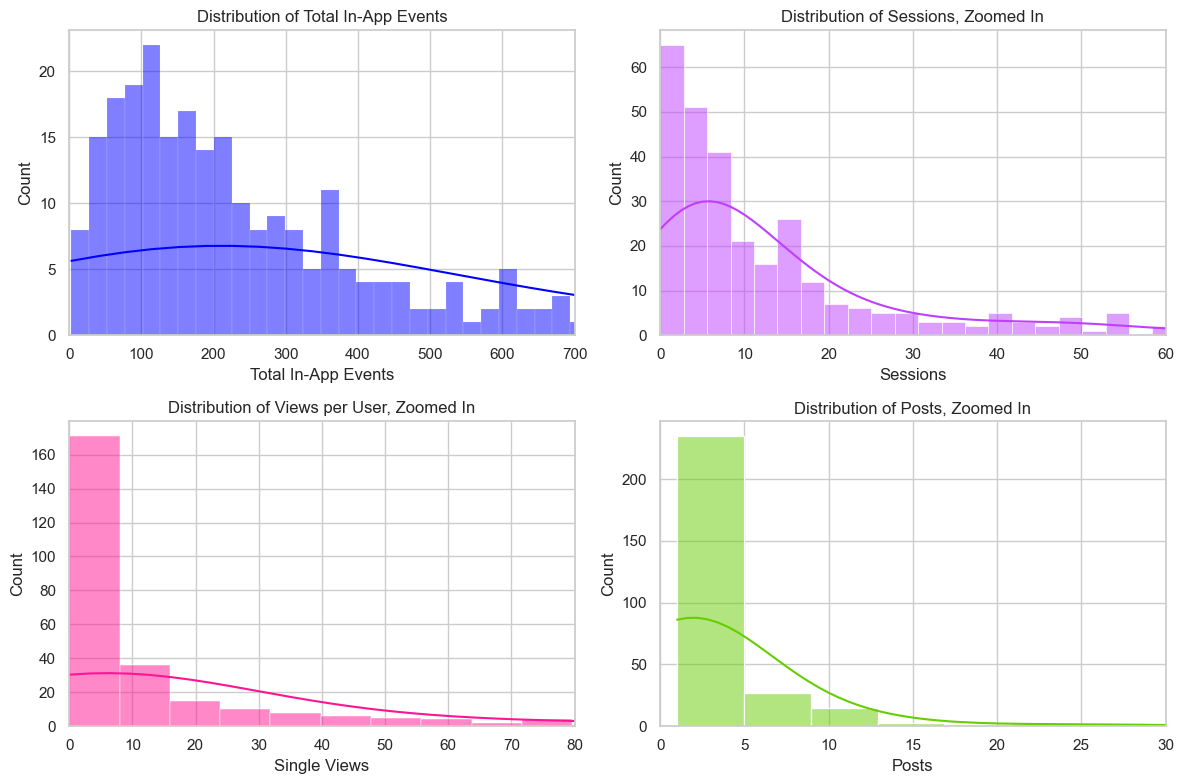

In [22]:
# Distribution of KPIs for Creators. Zooming in by limiting x-axis to better visualize the data.

columns_to_sum_creators    = creators.columns[creators.columns != 'User ID']  
creators['SUM']            = creators[columns_to_sum_creators].sum(axis=1) 

sns.set(font_scale=1, style='whitegrid')

# Create a figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Distribution of Total In-App Events
sns.histplot(creators['SUM'], color='#0000FF', kde=True, bins=300, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Total In-App Events')
axes[0, 0].set_xlim(0, 700)
axes[0, 0].set_xlabel('Total In-App Events')

# Distribution of Sessions
sns.histplot(creators['session_start'], color='#BF3EFF', kde=True, bins=60, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Sessions, Zoomed In')
axes[0, 1].set_xlim(0, 60)
axes[0, 1].set_xlabel('Sessions')

# Distribution of Views per User
sns.histplot(creators['discover_story_detail_open'], color='#FF1493', kde=True, bins=80, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Views per User, Zoomed In')
axes[1, 0].set_xlim(0, 80)
axes[1, 0].set_xlabel('Single Views')

# Distribution of Posts
sns.histplot(creators['Posts'], color='#66CD00', kde=True, bins=30, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Posts, Zoomed In')
axes[1, 1].set_xlim(0, 30)

plt.tight_layout()
plt.show()

creators = creators.drop(['SUM'], axis=1)

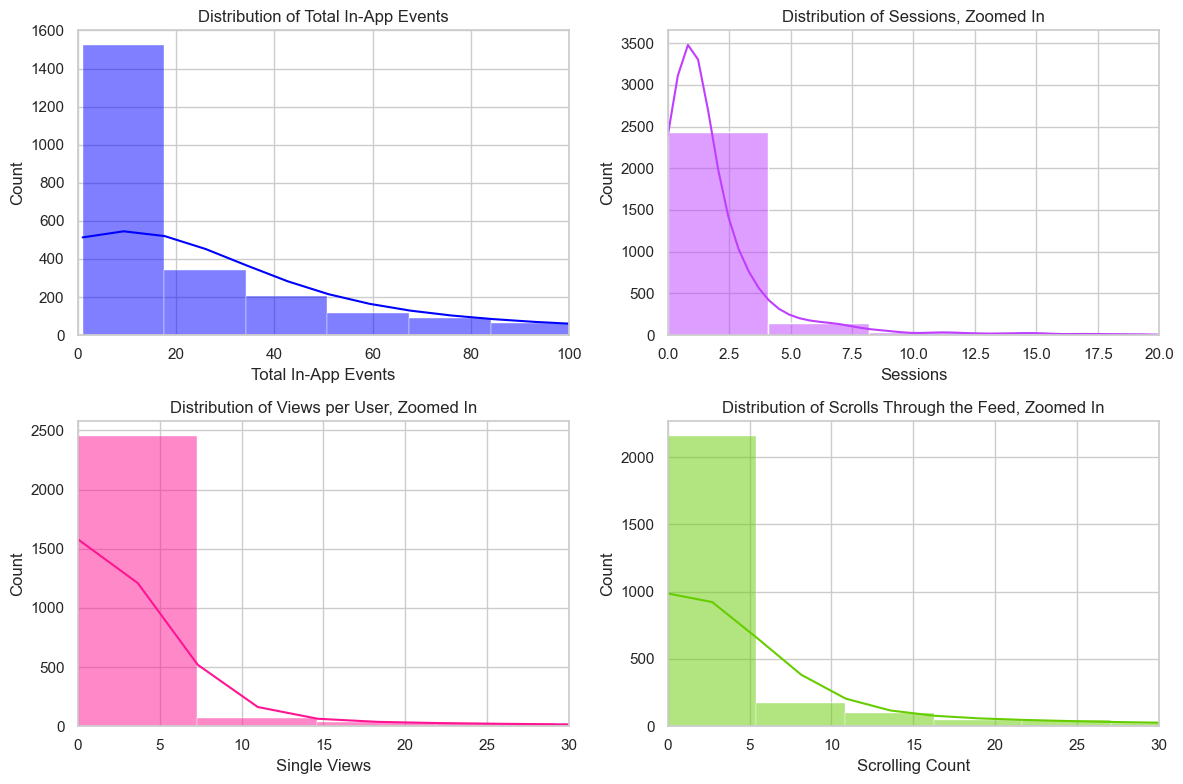

In [23]:
# Distribution of KPIs for Spectators. Zooming in by limiting x-axis by to better visualize the data.

columns_to_sum_spectators = spectators.columns[spectators.columns != 'User ID']  
spectators['SUM'] = spectators[columns_to_sum_spectators].sum(axis=1) 

sns.set(font_scale=1, style='whitegrid')

# Create a figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Distribution of Total In-App Events
sns.histplot(spectators['SUM'], color='#0000FF', kde=True, bins=100, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Total In-App Events')
axes[0, 0].set_xlim(0, 100)
axes[0, 0].set_xlabel('Total In-App Events')

# Distribution of Sessions
sns.histplot(spectators['session_start'], color='#BF3EFF', kde=True, bins=20, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Sessions, Zoomed In')
axes[0, 1].set_xlim(0, 20)
axes[0, 1].set_xlabel('Sessions')

# Distribution of Views per User
sns.histplot(spectators['discover_story_detail_open'], color='#FF1493', kde=True, bins=100, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Views per User, Zoomed In')
axes[1, 0].set_xlim(0, 30)
axes[1, 0].set_xlabel('Single Views')

# Distribution of Scrolling Throught the Feed
sns.histplot(spectators['community_feed_scroll_start'], color='#66CD00', kde=True, bins=100, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Scrolls Through the Feed, Zoomed In')
axes[1, 1].set_xlim(0, 30)
axes[1, 1].set_xlabel('Scrolling Count')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

spectators = spectators.drop(['SUM'], axis=1)

# Dimension Reduction

### Principal Component Analysis (PCA) 

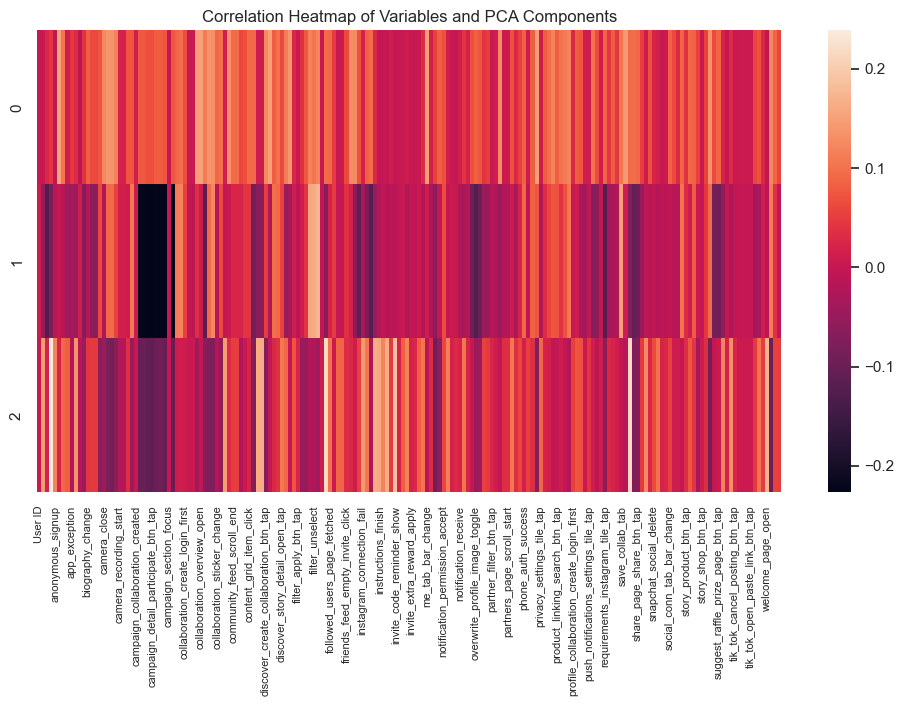

In [24]:
scaler      = StandardScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)
pca         = PCA(n_components = 3)
pca.fit(scaled_data)
x_pca       = pca.transform(scaled_data)

# Visualize the Correlation
pca_comp    = pca.components_
data_comp   = pd.DataFrame(pca.components_, columns = data.columns)
  
plt.figure(figsize =(12, 6))
heatmap     = sns.heatmap(data_comp)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize = 8)
plt.title('Correlation Heatmap of Variables and PCA Components')
plt.show()

This graph is hard to interpret. I need to optimize it
## Explained Variance

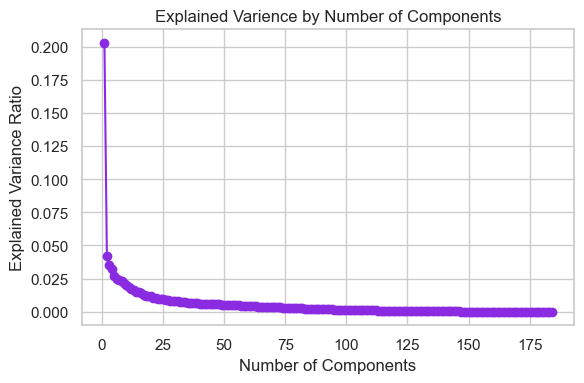

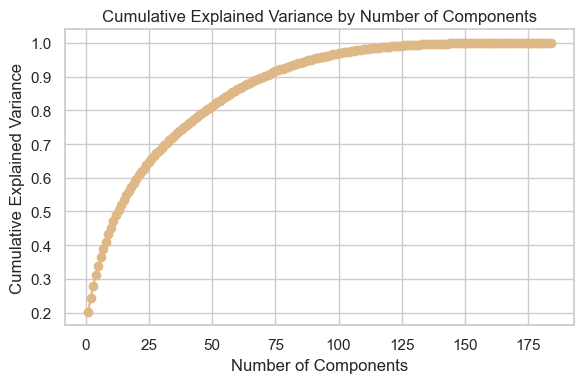

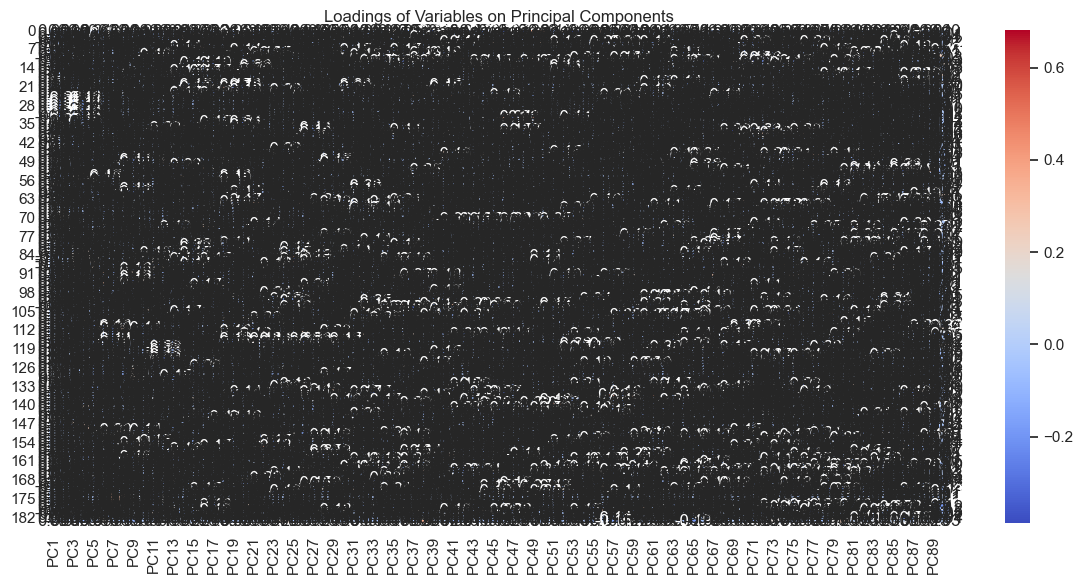

In [25]:
# Select the numerical columns for PCA
data_numeric = data.select_dtypes(include=[np.number])

# Standardize the data
scaler       = StandardScaler()
scaled_data  = scaler.fit_transform(data_numeric)
pca          = PCA()
pca.fit(scaled_data)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance      = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', color="#8A2BE2")
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Varience by Number of Components')
plt.tight_layout()
plt.show()

# Plot cumulative explained variance
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o',color="#DEB887")
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.tight_layout()
plt.show()

# Select subset of components based on desired explained variance threshold
desired_variance_threshold = 0.95
n_components = np.argmax(cumulative_variance >= desired_variance_threshold) + 1

# Perform PCA with selected number of components
pca          = PCA(n_components=n_components)
pca.fit(scaled_data)
reduced_data = pca.transform(scaled_data)

# Interpret the components by examining loadings
loadings     = pd.DataFrame(pca.components_.T, columns=[f'PC{i}' for i in range(1, n_components + 1)])
plt.figure(figsize=(12, 6))
sns.heatmap(loadings, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Loadings of Variables on Principal Components')
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=8)
plt.tight_layout()
plt.show()

The graph seems too messy to interpret. Trying another method
## Correlation Coefficient

In [26]:
# Find columns that have low correlation with the components
# Convert x_pca to a Pandas Series for the three PCA components
pca_component_1  = pd.Series(x_pca[:, 0])
pca_component_2  = pd.Series(x_pca[:, 1])
pca_component_3  = pd.Series(x_pca[:, 2])

# Initialize a list to store the columns with correlation between -0.3 and 0.3
limited_correlation_columns = []

# Iterate over the columns of data_comp DataFrame
for column in data_comp.columns:
    correlation_1 = abs(data_comp[column].corr(pca_component_1))  
    correlation_2 = abs(data_comp[column].corr(pca_component_2))  
    correlation_3 = abs(data_comp[column].corr(pca_component_3))  
    if -0.3 <= correlation_1 <= 0.3 or -0.3 <= correlation_2 <= 0.3 or -0.3 <= correlation_3 <= 0.3:
        limited_correlation_columns.append(column)

print("Columns with correlation between -0.3 and 0.3 for at least one of the three PCA components:")
for column in limited_correlation_columns:
    print(column)

Columns with correlation between -0.3 and 0.3 for at least one of the three PCA components:
User ID
account_infos_tile_tap
anonymous_signup
app_bar_profile_tap
app_clear_data
app_exception
app_infos_settings_tile_tap
app_remove
app_update
biography_change
camera_capture_btn_tap
camera_gallery_btn_tap
camera_media_confirm
camera_recording_start
camera_recording_stop
camera_sticker_btn_tap
camera_switch
campaign_detail_focused_header_image
campaign_detail_open
campaign_detail_participate
campaign_detail_participate_btn_tap
campaign_detail_scroll_end
campaign_detail_scroll_start
campaign_preview_media_tap
campaign_section_focus
campaign_tile_tap
collab_confirm_platform_btn_tap_disabled
collab_platform_select_modal_open
collaboration_create_login_first
collaboration_select_instagram_btn_tap
collaboration_select_partner_btn_tap
collaboration_select_yamuntu_btn_tap
collabs_overview_add_btn_tap
collabs_overview_first_time_open
community_feed_page_fetched
community_feed_scroll_end
community_fe

In [27]:
# Remove the above columns from the dataset for further analysis. Keep columns "discover_story_detail_open", "session_start", "Posts" as core KPIs
columns_to_remove = [column for column in limited_correlation_columns if column not in ["discover_story_detail_open", "session_start", "Posts"]]
data_high_corr    = data.drop(columns_to_remove, axis=1)
data_high_corr.shape[1]

63

#### Perform PCA on high correlation dataset

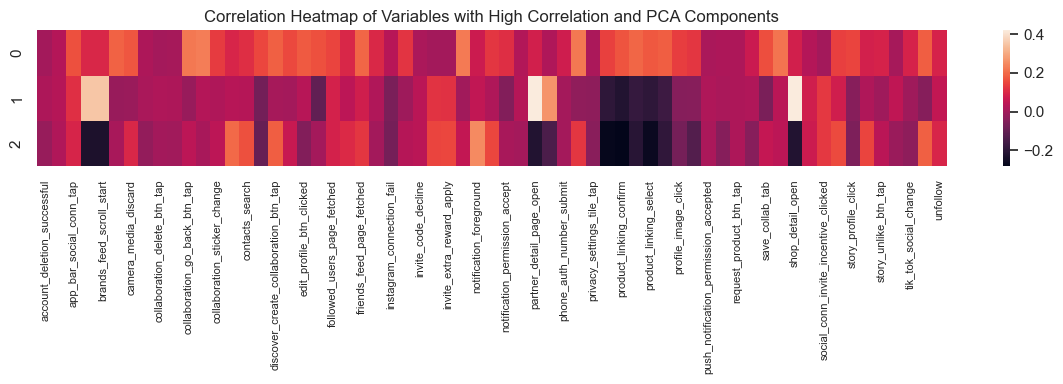

In [28]:
scaler                 = StandardScaler()
scaler.fit(data_high_corr)
scaled_data_high_corr  = scaler.transform(data_high_corr)
pca                    = PCA(n_components = 3)
pca.fit(scaled_data_high_corr)
x_pca                  = pca.transform(scaled_data_high_corr)

# Visualize the Correlation
pca_comp               = pca.components_
data_comp_high_corr    = pd.DataFrame(pca.components_, columns = data_high_corr.columns)

plt.figure(figsize =(12, 4))
heatmap                = sns.heatmap(data_comp_high_corr)

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize = 8)
plt.title('Correlation Heatmap of Variables with High Correlation and PCA Components')
plt.tight_layout()
plt.show()

#### PCA for top 16 and 26 columns 

In [29]:
# Create 2 new datasets. For top 10 and top 25 columns + Posts
variances      = data.var()
sorted_columns = variances.sort_values(ascending=False)

# Select the top 15 and 25 columns with the highest variances
top_16_columns = sorted_columns[:15].index.tolist()
top_26_columns = sorted_columns[:25].index.tolist()

# Include 'Posts' column in the selected columns
top_16_columns.append('Posts')
top_26_columns.append('Posts')

# Create new dataframes using only the selected columns
df_top_16      = data[top_16_columns].copy()
df_top_26      = data[top_26_columns].copy()

(2940, 16)
(2940, 3)


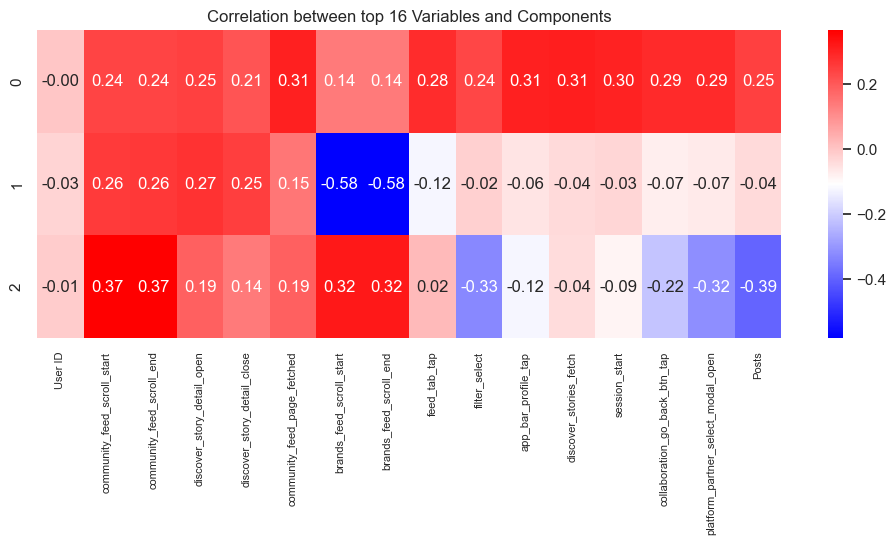

In [30]:
# PCA for top 16 columns
scaler         = StandardScaler()
scaled_data16  = scaler.fit_transform(df_top_16)
n_components   = 3
pca            = PCA(n_components=n_components)
pca.fit(scaled_data16)
x_pca16        = pca.transform(scaled_data16)

print(scaled_data16.shape)
print(x_pca16.shape)

pca_comp16     = pca.components_
data_comp16    = pd.DataFrame(pca_comp16, columns=df_top_16.columns)

# Plot the correlation between variables and components
plt.figure(figsize=(12, 4))
heatmap        = sns.heatmap(data_comp16, cmap='bwr', annot=True, fmt='.2f')

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=8)
plt.title('Correlation between top 16 Variables and Components')
plt.show()

(2940, 26)
(2940, 3)


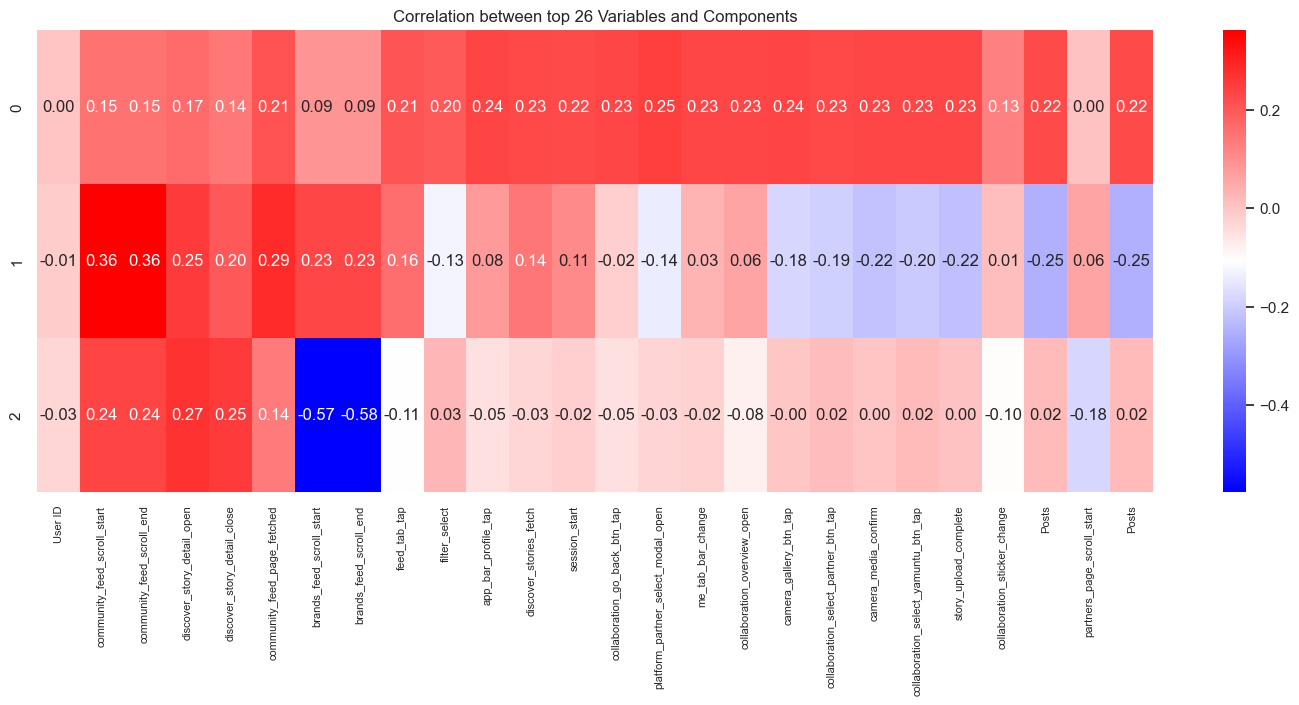

In [31]:
# PCA for top 26 columns
scaler        = StandardScaler()
scaled_data26 = scaler.fit_transform(df_top_26)
n_components  = 3
pca           = PCA(n_components=n_components)
pca.fit(scaled_data26)
x_pca26       = pca.transform(scaled_data26)

print(scaled_data26.shape)
print(x_pca26.shape)

pca_comp26    = pca.components_
data_comp26   = pd.DataFrame(pca_comp26, columns=df_top_26.columns)

plt.figure(figsize=(18, 6))
heatmap       = sns.heatmap(data_comp26, cmap='bwr', annot=True, fmt='.2f')

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=8)
plt.title('Correlation between top 26 Variables and Components')
plt.show()

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

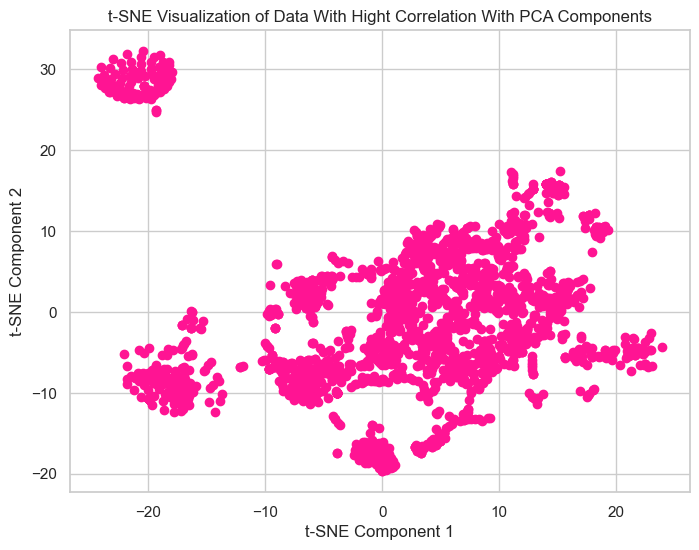

In [32]:
# Perform t-SNE with 3 components
tsne         = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(scaled_data_high_corr)

# Scatter plot of the t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], color="#FF1493")
plt.title('t-SNE Visualization of Data With Hight Correlation With PCA Components')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

/var/folders/f2/51x8sc3d7yqctdsgf4tqr6c80000gn/T/ipykernel_52580/712137895.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], cmap="Set2_r")


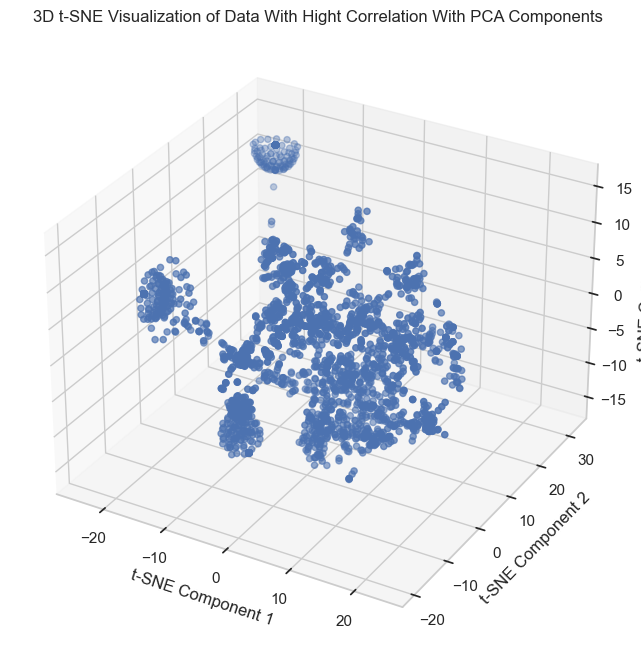

In [33]:
# Perform t-SNE with 3 components
tsne         = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(scaled_data_high_corr)

# Create a 3D scatter plot of the t-SNE results
fig          = plt.figure(figsize=(10, 8))
ax           = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], cmap="Set2_r")
ax.set_title('3D t-SNE Visualization of Data With Hight Correlation With PCA Components')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.show()

## UMAP 

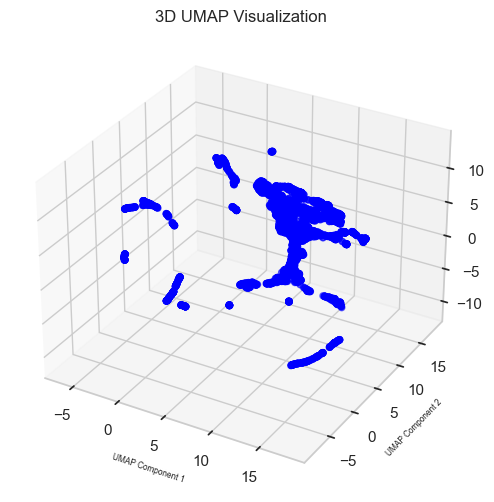

In [34]:
scaler      = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Perform PCA
pca         = PCA(n_components=3)
x_pca       = pca.fit_transform(scaled_data)

# Perform UMAP with adjusted parameters
umap_model  = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
umap_results= umap_model.fit_transform(x_pca)

# Create a 3D scatter plot of the UMAP results
fig         = plt.figure(figsize=(18, 6))
ax          = fig.add_subplot(111, projection='3d')
ax.scatter(umap_results[:, 0], umap_results[:, 1], umap_results[:, 2], color="#0000FF")
ax.set_title('3D UMAP Visualization')
ax.set_xlabel('UMAP Component 1', fontsize=6)
ax.set_ylabel('UMAP Component 2', fontsize=6)
ax.set_zlabel('UMAP Component 3', fontsize=6)

plt.show()


## K-MEANS CLUSTERING

### Elbow method for all 6 datasets
HC == high correlation

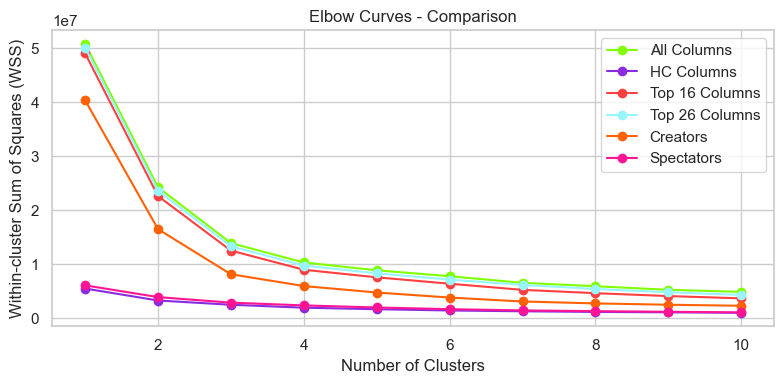

In [35]:
# Elbow method
def plot_elbow_curves(data_list, labels_list):
    wss_list = []

    for data in data_list:
        wss  = []
        for i in range(1, 11):
            kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
            kmeans.fit(data)
            wss.append(kmeans.inertia_)
        wss_list.append(wss)

    # Create a single subplot for all graphs
    fig, ax  = plt.subplots(figsize=(8, 4))

    # Plot elbow curves
    colors   = ["#7FFF00", "#8A2BE2", "#FF4040", "#98F5FF", "#FF6103", "#FF1493"]
    for i, wss in enumerate(wss_list):
        ax.plot(range(1, 11), wss, marker='o', color=colors[i], label=labels_list[i])

    ax.set_title('Elbow Curves - Comparison')
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Within-cluster Sum of Squares (WSS)')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Remove the 'User ID' column
data_no_id       = data.drop('User ID', axis=1)
data_no_id_16    = df_top_16.drop('User ID', axis=1)
data_no_id_26    = df_top_26.drop('User ID', axis=1)
creators_no_id   = creators.drop('User ID', axis=1)
spectators_no_id = spectators.drop('User ID', axis=1)

# Define the datasets and their corresponding labels
data_list        = [data_no_id, data_high_corr, data_no_id_16, data_no_id_26, creators_no_id, spectators_no_id]
labels_list      = ['All Columns', 'HC Columns', 'Top 16 Columns', 'Top 26 Columns', 'Creators', 'Spectators']
plot_elbow_curves(data_list, labels_list)

### Creating K-Means Clusters

In [36]:
# Setting up 3 clusters and fit model to the data
kmeans_data_no_id = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_data_no_id.fit(data_no_id)

# Get the cluster assignments for each data point:
cluster_assignments_data_no_id = kmeans_data_no_id.predict(data_no_id)

# Add the cluster assignments to your original data frame:
data_no_id['Cluster']          = cluster_assignments_data_no_id
data_no_id.value_counts('Cluster')

Cluster
0    2905
2      32
1       3
dtype: int64

##### Repeat steps for other datasets

In [37]:
kmeans_data_high_corr              = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_data_high_corr.fit(data_high_corr)
cluster_assignments_data_high_corr = kmeans_data_high_corr.predict(data_high_corr)
data_high_corr['Cluster']          = cluster_assignments_data_high_corr
data_high_corr.value_counts('Cluster')

Cluster
1    2768
0     143
2      29
dtype: int64

In [38]:
kmeans_data_no_id_16              = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_data_no_id_16.fit(data_no_id_16)
cluster_assignments_data_no_id_16 = kmeans_data_no_id_16.predict(data_no_id_16)
data_no_id_16['Cluster']          = cluster_assignments_data_no_id_16
data_no_id_16.to_csv('users_clusters_data_no_id_16.csv', index=False)
data_no_id_16.value_counts('Cluster')

Cluster
0    2906
2      31
1       3
dtype: int64

In [39]:
kmeans_data_no_id_26              = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_data_no_id_26.fit(data_no_id_26)
cluster_assignments_data_no_id_26 = kmeans_data_no_id_26.predict(data_no_id_26)
data_no_id_26['Cluster']          = cluster_assignments_data_no_id_26
data_no_id_26.value_counts('Cluster')

Cluster
0    2905
2      32
1       3
dtype: int64

In [40]:
kmeans_creators                    = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_pred_creators                    = kmeans_creators.fit(creators)
cluster_assignments_creators       = kmeans_creators.predict(creators)
creators['Cluster']                = cluster_assignments_creators
creators.value_counts('Cluster')

Cluster
0    160
1    134
dtype: int64

In [41]:
kmeans_spectators                  = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_pred_spectators                  = kmeans_spectators.fit(spectators)
cluster_assignments_spectators     = kmeans_spectators.predict(spectators)
spectators['Cluster']              = cluster_assignments_spectators
spectators.value_counts('Cluster')

Cluster
1    1336
0    1310
dtype: int64

In [42]:
creators[creators['Cluster']==1]['Posts'].describe()

count    134.000000
mean       4.850746
std       12.930414
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max      117.000000
Name: Posts, dtype: float64

In [43]:
creators[creators['Cluster']==0]['Posts'].describe()

count    160.000000
mean       5.550000
std       14.963604
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max      120.000000
Name: Posts, dtype: float64

#### Vsualizing K-Means Clusters

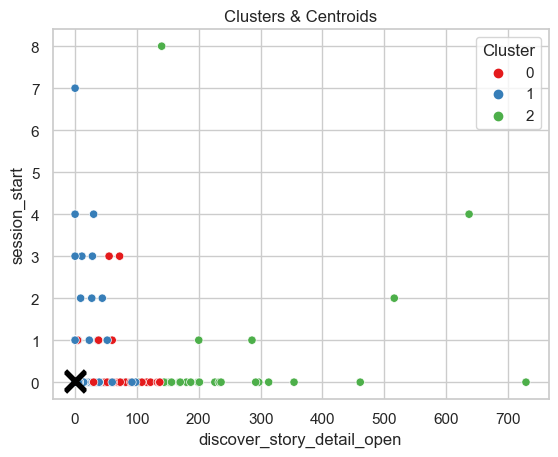

In [44]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='discover_story_detail_open', y='contact_invite', hue='Cluster', data=data_high_corr, palette='Set1')

# Add the centroids
centroids_data_high_corr = kmeans_data_high_corr.cluster_centers_
plt.scatter(centroids_data_high_corr[:, 0], centroids_data_high_corr[:, 1], marker='x', s=200, linewidths=3, color='black')

plt.title('Clusters & Centroids')
plt.xlabel('discover_story_detail_open')
plt.ylabel('session_start')
plt.show()

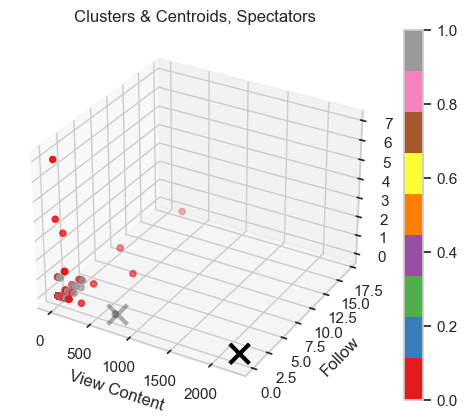

In [45]:
features = ['discover_story_detail_open', 'follow', 'contact_invite']

# Plot the data points with different colors for each cluster
fig      = plt.figure()
ax       = fig.add_subplot(111, projection='3d')

scatter  = ax.scatter(spectators[features[0]], spectators[features[1]], spectators[features[2]], c=spectators['Cluster'], cmap='Set1')

# Add the centroids
centroids_spectators = kmeans_spectators.cluster_centers_
ax.scatter(centroids_spectators[:, 0], centroids_spectators[:, 1], centroids_spectators[:, 2], marker='x', s=200, linewidths=3, color='black')

# Set labels for the three axes
ax.set_xlabel('View Content')
ax.set_ylabel('Follow')
ax.set_zlabel('Invite Contact')

plt.title('Clusters & Centroids, Spectators')
plt.colorbar(scatter)
plt.show()


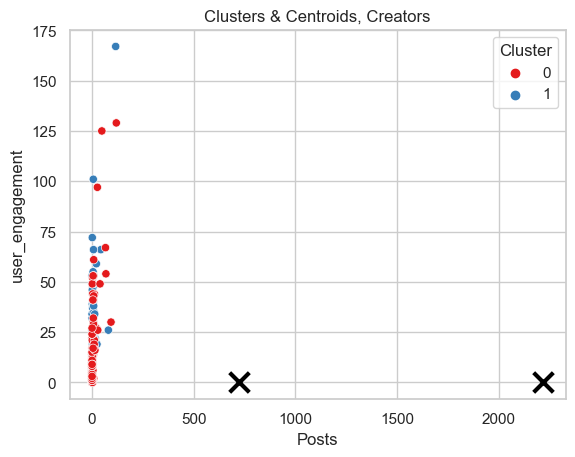

In [46]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Posts', y='session_start', hue='Cluster', data=creators, palette='Set1')

# Add the centroids
centroids_creators = kmeans_creators.cluster_centers_
plt.scatter(centroids_creators[:, 0], centroids_creators[:, 1], marker='x', s=200, linewidths=3, color='black')

# Set the title and labels for the plot
plt.title('Clusters & Centroids, Creators')
plt.xlabel('Posts')
plt.ylabel('user_engagement')

# Show the plot'
plt.show()

In [47]:
# Perform PCA on creators
pca_creators   = PCA(n_components=2)
pca_creators   = pca_creators.fit_transform(creators)
pca_creators   = pd.DataFrame(pca_creators, columns=['pca_1', 'pca_2'])

# Perform PCA on spectators
pca_spectators = PCA(n_components=2)
pca_spectators = pca_spectators.fit_transform(spectators)
pca_spectators = pd.DataFrame(pca_spectators, columns=['pca_1', 'pca_2'])

/Applications/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Applications/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


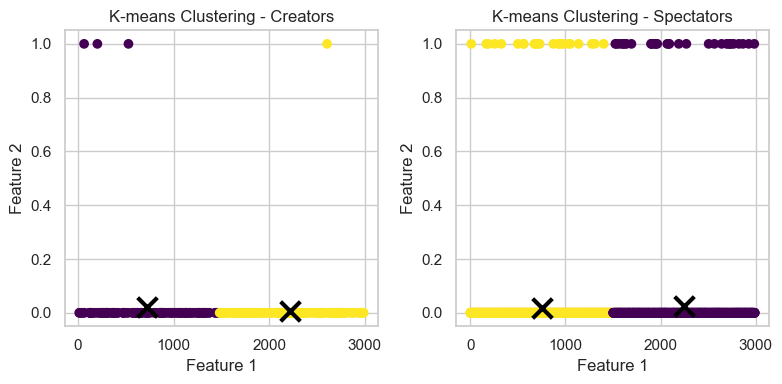

In [48]:
fig, axes   = plt.subplots(1, 2, figsize=(8, 4))

# Loop through the datasets and plot the clusters for each
datasets    = [creators, spectators]
titles      = ['Creators', 'Spectators']
for i, ax in enumerate(axes):
    # Perform clustering and assign cluster labels
    kmeans  = KMeans(n_clusters=2)
    y_pred_ = kmeans.fit_predict(datasets[i].values)  # Convert DataFrame to NumPy array

    # Plot the data points with different colors for each cluster
    ax.scatter(datasets[i].values[:, 0], datasets[i].values[:, 1], c=y_pred_, cmap='viridis')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(f'K-means Clustering - {titles[i]}')
    centroids = kmeans.cluster_centers_
    ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='black')

plt.tight_layout()
plt.show()

/Applications/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Applications/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


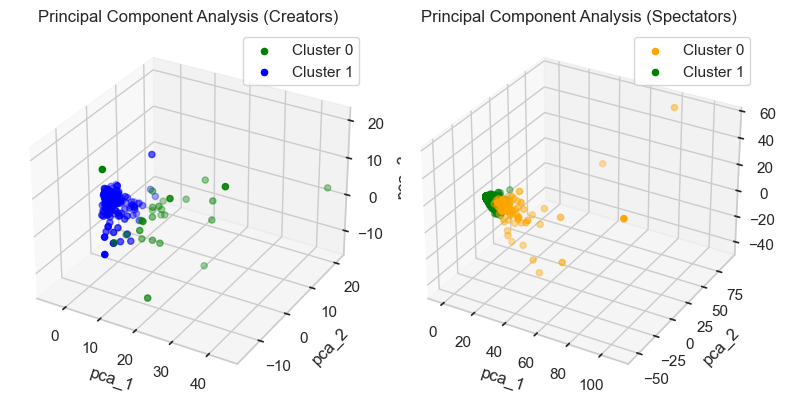

In [49]:
# Perform PCA and create a DataFrame with the transformed data for creators

scaled_creators   = scaler.fit_transform(creators)
y_pred_creators   = kmeans.fit_predict(scaled_creators)
pca_creators      = PCA(n_components=3)
pca_creators_data = pca_creators.fit_transform(scaled_creators)
pca_creators_df   = pd.DataFrame(pca_creators_data, columns=['pca_1', 'pca_2', 'pca_3'])
pca_creators_df['Cluster'] = y_pred_creators

# Perform PCA and create a DataFrame with the transformed data for spectators
scaled_spectators   = scaler.fit_transform(spectators)
y_pred_spectators   = kmeans.fit_predict(scaled_spectators)
pca_spectators      = PCA(n_components=3)
pca_spectators_data = pca_spectators.fit_transform(scaled_spectators)
pca_spectators_df   = pd.DataFrame(pca_spectators_data, columns=['pca_1', 'pca_2', 'pca_3'])
pca_spectators_df['Cluster'] = y_pred_spectators

fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(8, 4), subplot_kw={'projection': '3d'})

# Plot PCA for creators
colors_creators= ['green', 'blue', 'orange']
for i in range(2):
    cluster_creators= pca_creators_df[pca_creators_df['Cluster'] == i]
    ax1.scatter(cluster_creators['pca_1'], cluster_creators['pca_2'], cluster_creators['pca_3'], c=colors_creators[i], label=f'Cluster {i}')
ax1.set_xlabel('pca_1')
ax1.set_ylabel('pca_2')
ax1.set_zlabel('pca_3')
ax1.legend()
ax1.set_title('Principal Component Analysis (Creators)')

# Plot PCA for spectators
colors_spectators = ['orange', 'green', 'blue']
for i in range(2):
    cluster_spectators = pca_spectators_df[pca_spectators_df['Cluster'] == i]
    ax2.scatter(cluster_spectators['pca_1'], cluster_spectators['pca_2'], cluster_spectators['pca_3'], c=colors_spectators[i], label=f'Cluster {i}')
ax2.set_xlabel('pca_1')
ax2.set_ylabel('pca_2')
ax2.set_zlabel('pca_3')
ax2.legend()
ax2.set_title('Principal Component Analysis (Spectators)')

plt.tight_layout()
plt.ioff()
plt.show()


### Cluster Investigation

In [50]:
# Calculate the variance of each column in datasets
variances_creators   = creators.var()
variances_spectators = spectators.var()

# Sort the columns based on their variances in descending order
sorted_columns_creators   = variances_creators.sort_values(ascending=False)
sorted_columns_spectators = variances_spectators.sort_values(ascending=False)

# Select the top 16 columns with the highest variances
top_16_columns_creators   = sorted_columns_creators[:16].index
top_16_columns_spectators = sorted_columns_spectators[:16].index

# Create new dataframes using only the selected columns
creators_top16   = creators[top_16_columns_creators].copy()
spectators_top16 = creators[top_16_columns_spectators].copy()

# Add column Posts, as it is one of the main KPIs
creators_top16['Posts']                        = creators['Posts']
creators_top16['session_start']                = creators['session_start']
spectators_top16['session_start']              = spectators['session_start']
spectators_top16['discover_story_detail_open'] = spectators['discover_story_detail_open']
spectators_top16.fillna(0)

,User ID,community_feed_scroll_start,community_feed_scroll_end,discover_story_detail_open,discover_story_detail_close,brands_feed_scroll_start,brands_feed_scroll_end,feed_tab_tap,community_feed_page_fetched,partners_page_scroll_start,partners_page_scroll_end,session_start,discover_stories_fetch,app_bar_profile_tap,request_product_btn_tap,collaboration_overview_open
12,13.0,522.0,518.0,0.0,540.0,51.0,48.0,297.0,210.0,0.0,0.0,0.0,157.0,125.0,2.0,117.0
20,21.0,84.0,84.0,0.0,30.0,9.0,9.0,5.0,21.0,0.0,0.0,0.0,11.0,6.0,0.0,0.0
23,24.0,3.0,3.0,0.0,0.0,1.0,1.0,16.0,4.0,0.0,0.0,0.0,3.0,5.0,0.0,2.0
40,41.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,19.0,0.0,0.0,0.0,22.0,25.0,0.0,15.0
54,55.0,42.0,42.0,0.0,41.0,3.0,3.0,28.0,17.0,0.0,0.0,0.0,10.0,20.0,0.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2951,2943.0,15.0,15.0,0.0,2.0,9.0,9.0,15.0,40.0,0.0,0.0,0.0,44.0,39.0,0.0,21.0
2970,2961.0,40.0,39.0,0.0,0.0,27.0,27.0,10.0,13.0,0.0,0.0,0.0,9.0,9.0,0.0,6.0
2988,2979.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,9.0,4.0,0.0,4.0
2992,2983.0,8.0,8.0,0.0,0.0,1.0,1.0,14.0,3.0,0.0,0.0,0.0,3.0,4.0,6.0,2.0


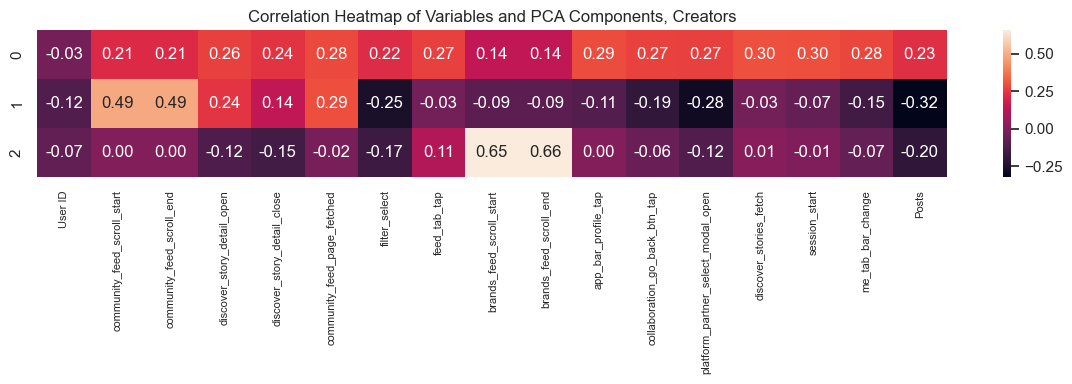

/Applications/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Applications/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Applications/anaconda3/lib/python3.10/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


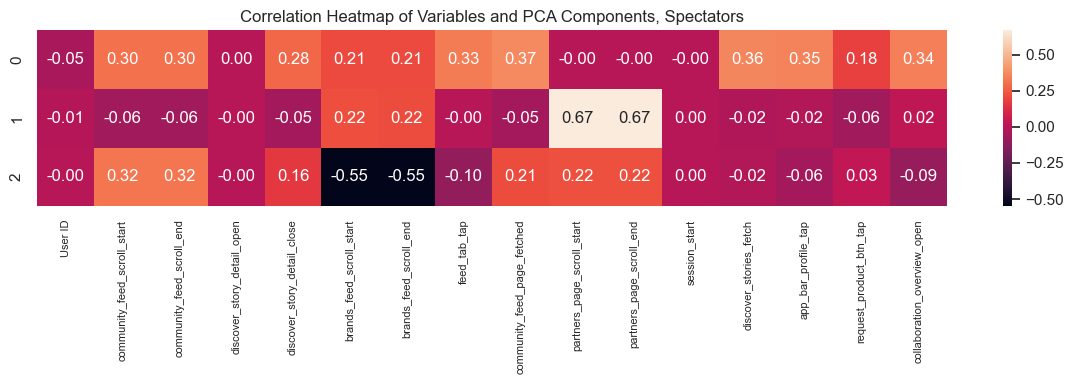

In [51]:
# PCA for high correlation data. CHC - creators high correlation
scaler.fit(creators_top16)
scaled_CHC    = scaler.transform(creators_top16)

# Specify the number of components
pca_CHC       = PCA(n_components = 3)
pca_CHC.fit(scaled_CHC)

# Transform the data to its first 3 principal components 
x_pca_CHC     = pca_CHC.transform(scaled_CHC)

# Visualize the Correlation
pca_comp_CHC  = pca_CHC.components_
comp_CHC      = pd.DataFrame(pca_CHC.components_, columns = creators_top16.columns)

plt.figure(figsize =(12, 4))
heatmap       = sns.heatmap(comp_CHC, annot=True, fmt=".2f")

# Decrease font size of x-axis labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize = 8)

plt.title('Correlation Heatmap of Variables and PCA Components, Creators')
plt.tight_layout()
plt.show()


# PCA for high correlation data. SHC - spectators high correlation
scaler.fit(spectators_top16)
scaled_SHC = scaler.transform(spectators_top16)
scaled_SHC = np.nan_to_num(scaled_SHC, nan=0.0)

# Specify the number of components
pca_SHC    = PCA(n_components = 3)
pca_SHC.fit(scaled_SHC)

# Transform the data to its first 3 principal components 
x_pca_SHC  = pca_SHC.transform(scaled_SHC)

# Visualize the Correlation
pca_comp_SHC  = pca_SHC.components_
comp_SHC   = pd.DataFrame(pca_SHC.components_, columns = spectators_top16.columns)

plt.figure(figsize =(12, 4))
heatmap    = sns.heatmap(comp_SHC,annot=True, fmt=".2f")
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize = 8)
plt.title('Correlation Heatmap of Variables and PCA Components, Spectators')
plt.tight_layout()
plt.show()

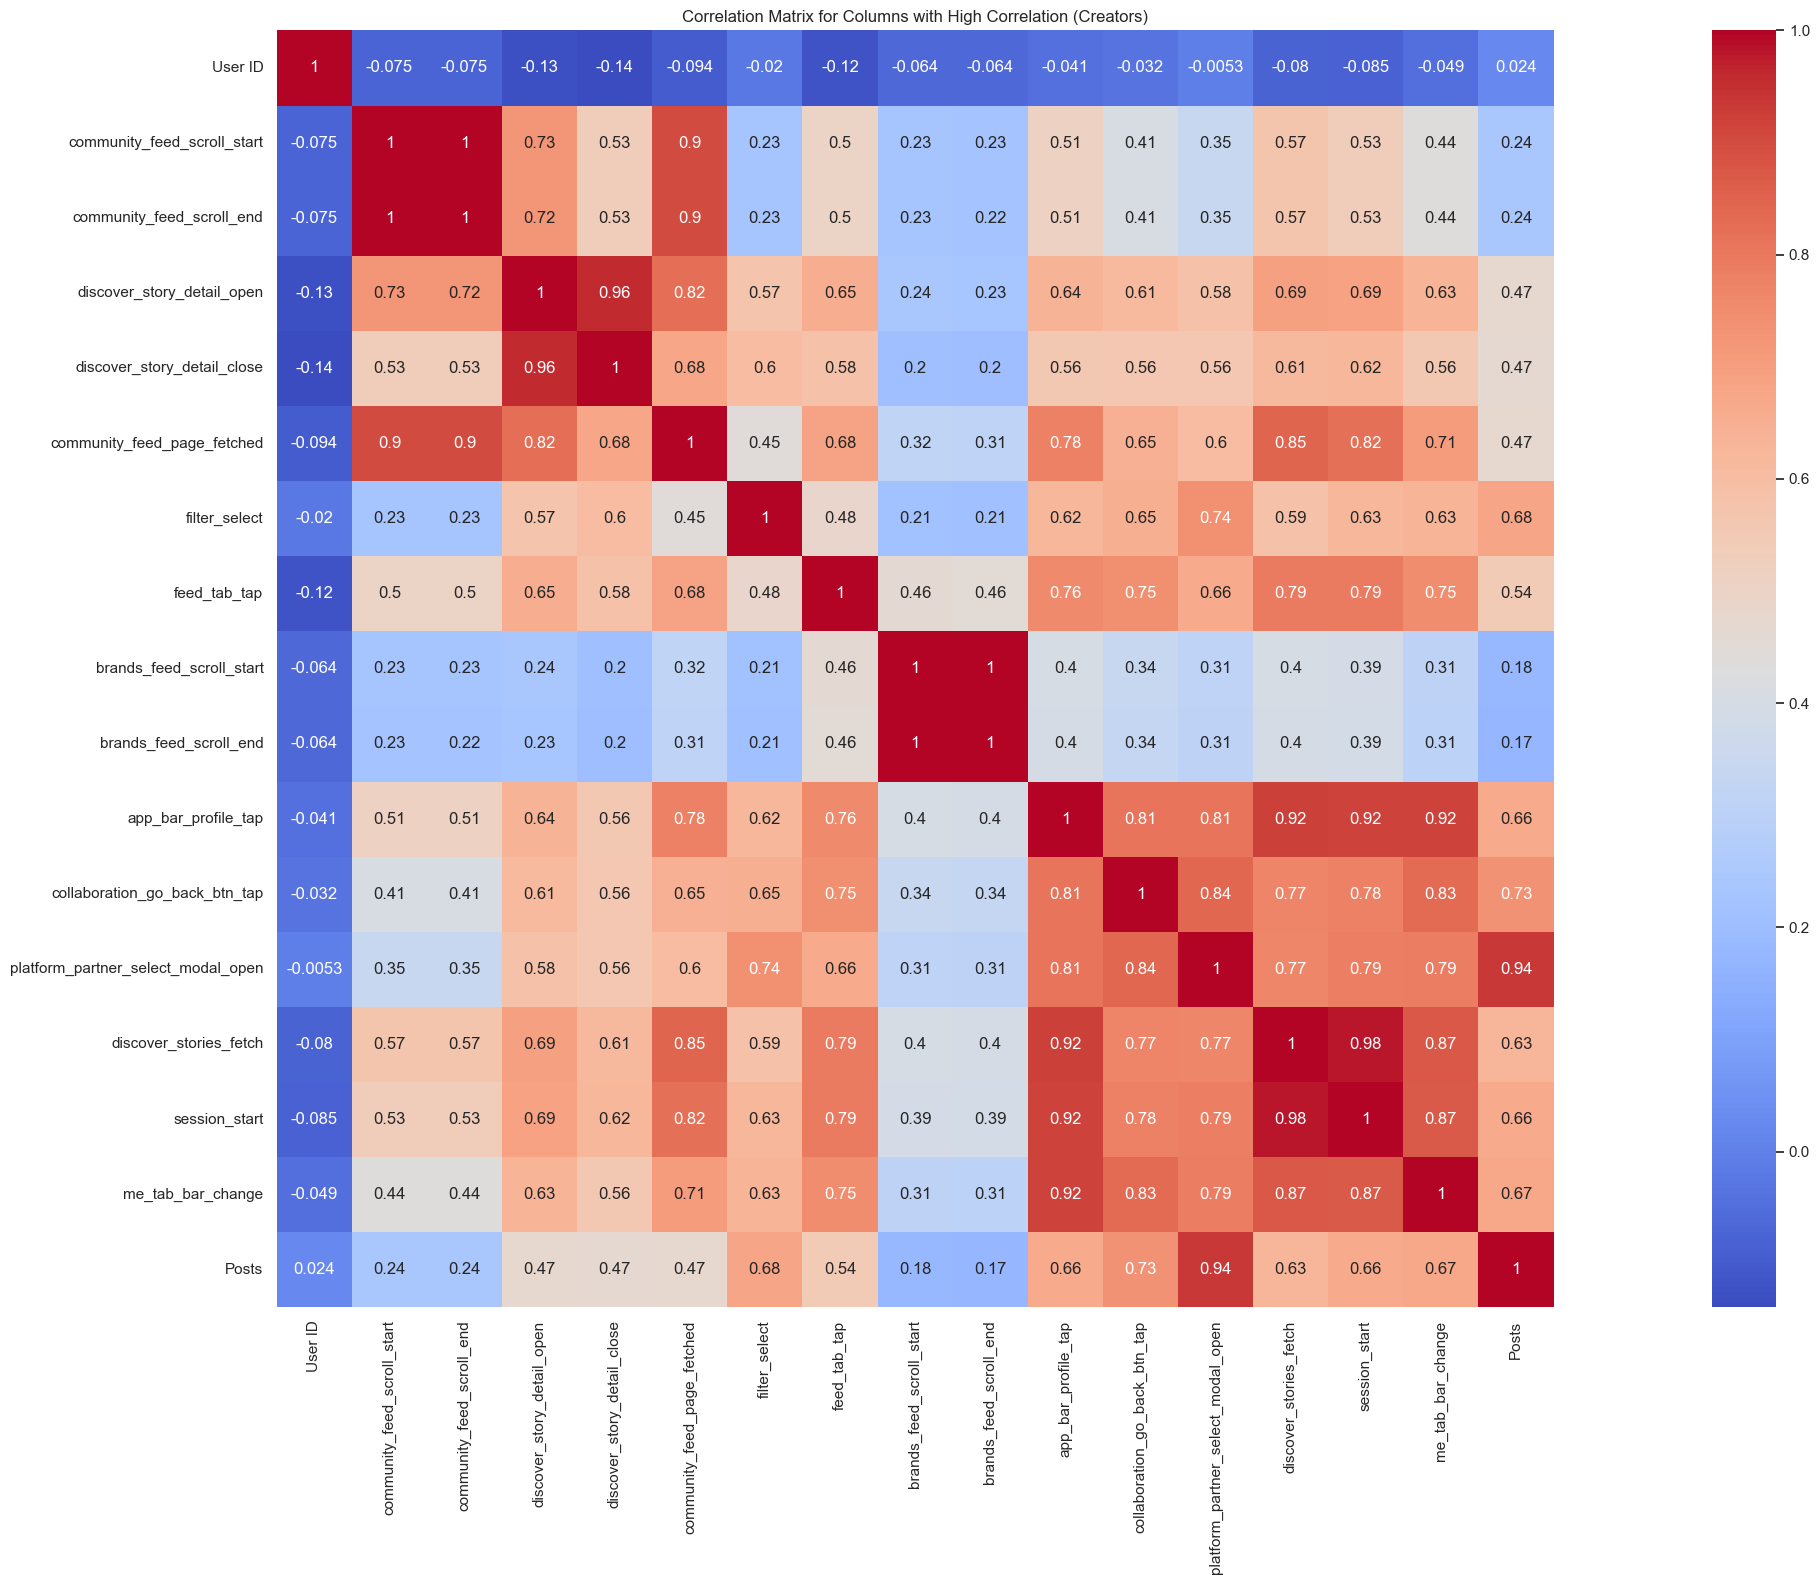

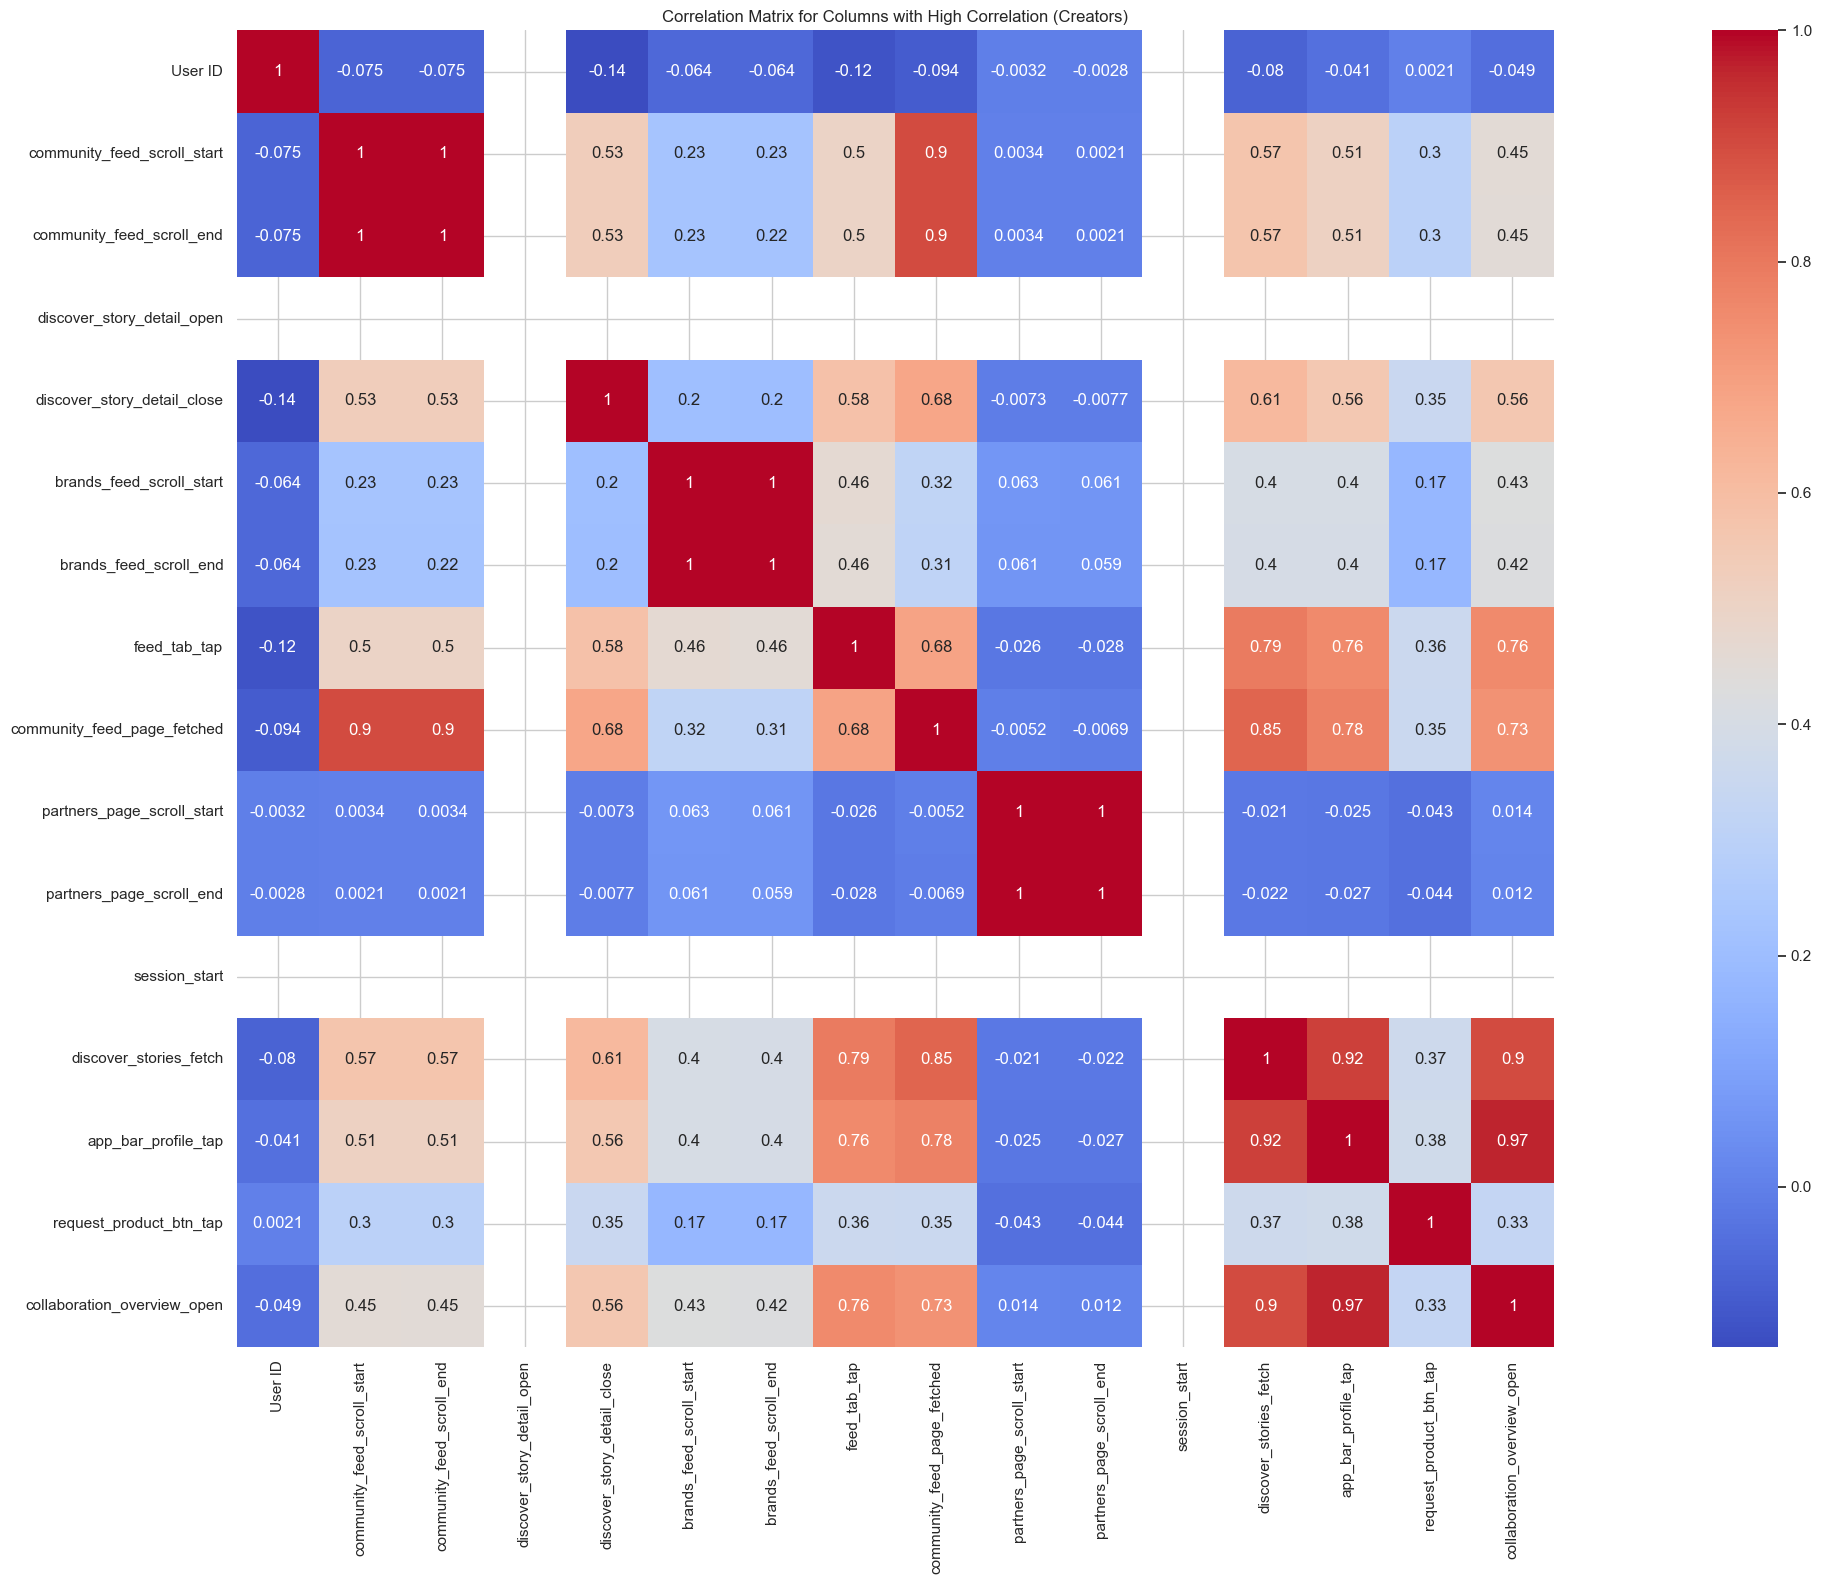

In [52]:
# Compute the correlation matrix
corr_matrix_CHC = creators_top16.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(32,16))
sns.heatmap(corr_matrix_CHC, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Matrix for Columns with High Correlation (Creators)")
plt.tight_layout()
plt.show()

corr_matrix_SHC = spectators_top16.corr()
plt.figure(figsize=(32,16))
sns.heatmap(corr_matrix_SHC, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Matrix for Columns with High Correlation (Creators)")
plt.tight_layout()
plt.show()

### Evaluation with Silhouette Score

In [53]:
labels_creators   = kmeans_creators.labels_
labels_spectators = kmeans_spectators.labels_

In [54]:
print(silhouette_score(creators, labels_creators))
print(silhouette_score(spectators, labels_spectators))

0.572605496970391
0.6203721383954584


In [55]:
silhouette_scores_creators = {}

for k in range(2, 8):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000)
    km.fit(creators)
    silhouette_scores_creators[k] = silhouette_score(creators, km.labels_)

silhouette_scores_spectators = {}

for k in range(2, 8):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000)
    km.fit(spectators)
    silhouette_scores_spectators[k] = silhouette_score(spectators, km.labels_)

/Applications/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Applications/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Applications/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Applications/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Applications/an

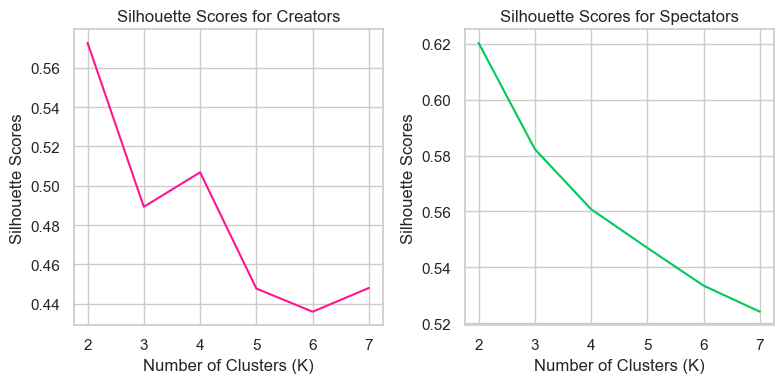

In [56]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot silhouette scores for creators
if silhouette_scores_creators:
    axes[0].plot(list(silhouette_scores_creators.keys()), list(silhouette_scores_creators.values()), color="#FF1493")
    axes[0].set_xlabel("Number of Clusters (K)")
    axes[0].set_ylabel("Silhouette Scores")
    axes[0].set_title("Silhouette Scores for Creators")
else:
    axes[0].text(0.5, 0.5, "Silhouette scores for creators not available.", ha="center", va="center", fontsize=12)

# Plot silhouette scores for spectators
if silhouette_scores_spectators:
    axes[1].plot(list(silhouette_scores_spectators.keys()), list(silhouette_scores_spectators.values()), color="#00C957")
    axes[1].set_xlabel("Number of Clusters (K)")
    axes[1].set_ylabel("Silhouette Scores")
    axes[1].set_title("Silhouette Scores for Spectators")
else:
    axes[1].text(0.5, 0.5, "Silhouette scores for spectators not available.", ha="center", va="center", fontsize=12)

plt.tight_layout()
plt.show()

## DBSCAN

### Cluster Distribution, creators

In [57]:
# Scale the data if needed
scaler = StandardScaler()
scaled_dbscan_creators = scaler.fit_transform(creators)

# Create DBSCAN object with adjusted parameters
dbscan_creators = DBSCAN(eps=2, min_samples=8)  

# Fit the DBSCAN model to the data
dbscan_creators.fit(scaled_dbscan_creators)

# Get the cluster labels
cluster_labels_dbscan_creators = dbscan_creators.labels_

# Get the number of clusters (-1 indicates noise/outliers)
num_clusters_dbscan_creators   = len(set(cluster_labels_dbscan_creators)) - (1 if -1 in cluster_labels_dbscan_creators else 0)
print(f"Number of clusters: {num_clusters_dbscan_creators}")

# Get the noise/outlier points
noise_points_dbscan_creators   = scaled_dbscan_creators[cluster_labels_dbscan_creators == -1]

creators['Cluster_dbscan']     = cluster_labels_dbscan_creators
cluster_counts_dbscan_creators = pd.Series(cluster_labels_dbscan_creators).value_counts()
creators['Cluster_dbscan'].value_counts()

Number of clusters: 2


-1    273
 0     12
 1      9
Name: Cluster_dbscan, dtype: int64

In [58]:
# Repeat for Spectators
scaler                           = StandardScaler()
scaled_dbscan_spectators         = scaler.fit_transform(spectators)
dbscan_spectators                = DBSCAN(eps=8, min_samples=16)  
dbscan_spectators.fit(scaled_dbscan_spectators)
cluster_labels_dbscan_spectators = dbscan_spectators.labels_
num_clusters_dbscan_spectators   = len(set(cluster_labels_dbscan_spectators)) - (1 if -1 in cluster_labels_dbscan_spectators else 0)
print(f"Number of clusters: {num_clusters_dbscan_spectators}")
noise_points_dbscan_spectatorss  = scaled_dbscan_spectators[cluster_labels_dbscan_spectators == -1]
spectators['Cluster_dbscan']     = cluster_labels_dbscan_spectators
cluster_counts_dbscan_spectators = pd.Series(cluster_labels_dbscan_spectators).value_counts()
spectators['Cluster_dbscan'].value_counts()

Number of clusters: 2


 0    2139
-1     483
 1      24
Name: Cluster_dbscan, dtype: int64

## K-Distance Curve

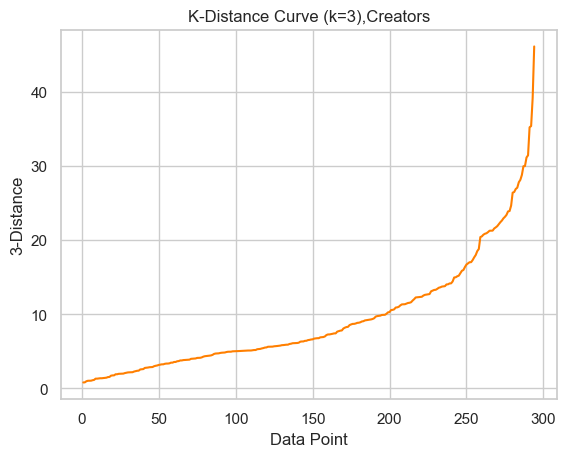

In [59]:
%matplotlib inline
# Compute the k-distance for each data point
k = 3
neighbors_model_creators  = NearestNeighbors(n_neighbors=k+1)
neighbors_model_creators.fit(scaled_dbscan_creators)
distances, _              = neighbors_model_creators.kneighbors(scaled_dbscan_creators)

# Sort the distances
sorted_distances_creators = np.sort(distances[:, k])

# Plot the k-distance curve
plt.plot(range(1, len(sorted_distances_creators) + 1), sorted_distances_creators, color="#FF7F00")
plt.xlabel('Data Point')
plt.ylabel(f'{k}-Distance')
plt.title(f'K-Distance Curve (k={k}),Creators')
plt.show()

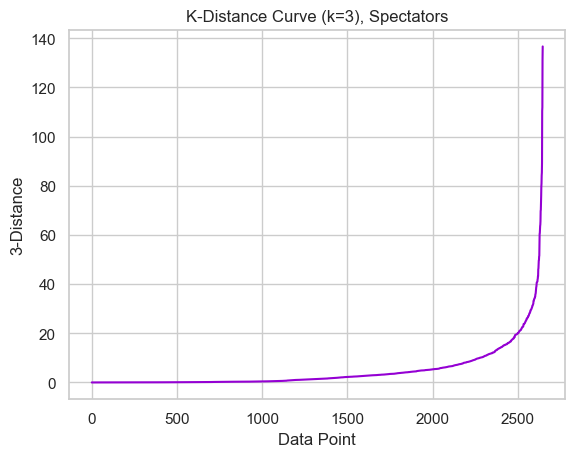

In [60]:
%matplotlib inline
# Repeat for Spectators
k = 3
neighbors_model_spectators  = NearestNeighbors(n_neighbors=k+1)
neighbors_model_spectators.fit(scaled_dbscan_spectators)
distances, _                = neighbors_model_spectators.kneighbors(scaled_dbscan_spectators)

# Sort the distances
sorted_distances_spectators = np.sort(distances[:, k])

# Plot the k-distance curve
plt.plot(range(1, len(sorted_distances_spectators) + 1), sorted_distances_spectators, color="#9400D3")
plt.xlabel('Data Point')
plt.ylabel(f'{k}-Distance')
plt.title(f'K-Distance Curve (k={k}), Spectators')
plt.show()

#### Visualize DBSCAN Clusters

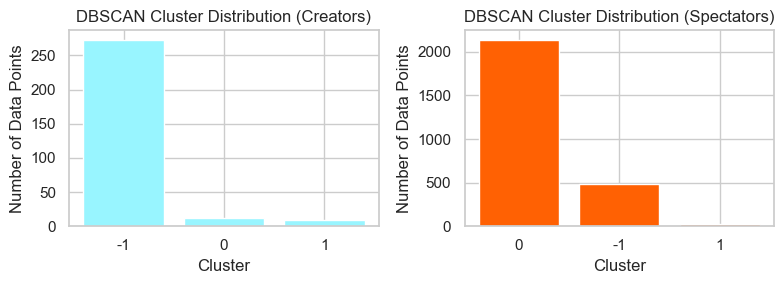

In [61]:
%matplotlib inline
# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Plot the first graph (DBSCAN Cluster Distribution - Creators)
axes[0].bar(cluster_counts_dbscan_creators.index.astype(str), cluster_counts_dbscan_creators.values, color ="#98F5FF")
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Number of Data Points')
axes[0].set_title('DBSCAN Cluster Distribution (Creators)')

# Plot the second graph (DBSCAN Cluster Distribution - Spectators)
axes[1].bar(cluster_counts_dbscan_spectators.index.astype(str), cluster_counts_dbscan_spectators.values, color ="#FF6103")
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Number of Data Points')
axes[1].set_title('DBSCAN Cluster Distribution (Spectators)')

plt.tight_layout()
plt.show()

## Merge the Creators and Spectators datasets in one

In [62]:
# Drop DBSCAN cluster column
creators = creators.drop(columns=['Cluster_dbscan'])
spectators = spectators.drop(columns=['Cluster_dbscan'])

# Relabel clusters to have 1,2,3,4
spectators.loc[spectators['Cluster'] == 0, 'Cluster'] = '2'
creators.loc[creators['Cluster'] == 0, 'Cluster'] = '3'
creators.loc[creators['Cluster'] == 1, 'Cluster'] = '4'

# Merge datasets
data_clusters = pd.concat([spectators, creators], ignore_index=True)
data_clusters.sort_values(by='User ID', ascending=True, inplace=True)
data_clusters["Cluster"] = data_clusters["Cluster"].astype("category")
data_clusters['Cluster'].value_counts()

1    1336
2    1310
3     160
4     134
Name: Cluster, dtype: int64

# Supervised Machine Learning

### Train and Test Models

In [63]:
train_data, test_data = train_test_split(data_clusters, test_size=0.2, random_state=42)
data_columns          = [column for column in data_clusters.columns.tolist() if column != 'Cluster']

### Logistic Regression

In [64]:
# Split the dataset into predictors (X) and target (y)
data_clusters["Cluster"] = data_clusters["Cluster"].astype(str)
X = data_clusters.drop("Cluster", axis=1)
y = data_clusters["Cluster"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the logistic regression model
logreg = LogisticRegression(fit_intercept=True, solver='lbfgs')
logreg.fit(X_train, y_train)

# Predict the clusters for the test set
y_pred = logreg.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.81      0.29      0.43       271
           2       0.55      0.96      0.70       254
           3       0.40      0.41      0.41        34
           4       0.72      0.45      0.55        29

    accuracy                           0.59       588
   macro avg       0.62      0.53      0.52       588
weighted avg       0.67      0.59      0.55       588



/Applications/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [65]:
data_clusters.head(3)

,User ID,account_deletion_successful,account_i_d_copy_tap,account_infos_tile_tap,anonymous_signup,app_bar_profile_tap,app_bar_social_conn_tap,app_clear_data,app_exception,app_infos_settings_tile_tap,...,tik_tok_link_submit_btn_tap,tik_tok_open_paste_link_btn_tap,tik_tok_social_change,tutorial_settings_tile_tap,username_change,welcome_page_open,Posts,follow,unfollow,Cluster
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1


In [66]:
cluster_encoded = pd.get_dummies(data_clusters['Cluster'], prefix='Cluster')
data_clusters_encoded = pd.concat([data_clusters, cluster_encoded], axis=1)
data_clusters_encoded.drop('Cluster', axis=1, inplace=True)

data_clusters_encoded.head(3)

,User ID,account_deletion_successful,account_i_d_copy_tap,account_infos_tile_tap,anonymous_signup,app_bar_profile_tap,app_bar_social_conn_tap,app_clear_data,app_exception,app_infos_settings_tile_tap,...,tutorial_settings_tile_tap,username_change,welcome_page_open,Posts,follow,unfollow,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
1,2.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0


In [67]:
data_1 = data_clusters_encoded[(data_clusters_encoded['Cluster_1'] == 1) & (data_clusters_encoded['Cluster_2'] == 0) & (data_clusters_encoded['Cluster_3'] == 0) & (data_clusters_encoded['Cluster_4'] == 0)]
data_2 = data_clusters_encoded[(data_clusters_encoded['Cluster_2'] == 1) & (data_clusters_encoded['Cluster_1'] == 0) & (data_clusters_encoded['Cluster_3'] == 0) & (data_clusters_encoded['Cluster_4'] == 0)]
data_3 = data_clusters_encoded[(data_clusters_encoded['Cluster_3'] == 1) & (data_clusters_encoded['Cluster_1'] == 0) & (data_clusters_encoded['Cluster_2'] == 0) & (data_clusters_encoded['Cluster_4'] == 0)]
data_4 = data_clusters_encoded[(data_clusters_encoded['Cluster_4'] == 1) & (data_clusters_encoded['Cluster_1'] == 0) & (data_clusters_encoded['Cluster_2'] == 0) & (data_clusters_encoded['Cluster_3'] == 0)]
data_1.head(3)

,User ID,account_deletion_successful,account_i_d_copy_tap,account_infos_tile_tap,anonymous_signup,app_bar_profile_tap,app_bar_social_conn_tap,app_clear_data,app_exception,app_infos_settings_tile_tap,...,tutorial_settings_tile_tap,username_change,welcome_page_open,Posts,follow,unfollow,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
1,2.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0


In [68]:
variances_1      = data_1.var()
variances_2      = data_2.var()
variances_3      = data_3.var()
variances_4      = data_4.var()

sorted_columns = variances.sort_values(ascending=False)


top_16_columns = sorted_columns[:15].index.tolist()
top_26_columns = sorted_columns[:25].index.tolist()

# Include 'Posts' column in the selected columns
top_16_columns.append('Posts')
top_26_columns.append('Posts')

# Create new dataframes using only the selected columns
df_top_16      = data[top_16_columns].copy()
df_top_26      = data[top_26_columns].copy()

In [69]:
top_16_columns

['User ID',
 'community_feed_scroll_start',
 'community_feed_scroll_end',
 'discover_story_detail_open',
 'discover_story_detail_close',
 'community_feed_page_fetched',
 'brands_feed_scroll_start',
 'brands_feed_scroll_end',
 'feed_tab_tap',
 'filter_select',
 'app_bar_profile_tap',
 'discover_stories_fetch',
 'session_start',
 'collaboration_go_back_btn_tap',
 'platform_partner_select_modal_open',
 'Posts']

In [70]:
predictors = top_16_columns

## Random Forest and Lasso Models

In [71]:
non_numeric_columns = test_data[predictors].select_dtypes(exclude=np.number).columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index([], dtype='object')


In [72]:
# Initiate Random Forest models 
rf         = RandomForestRegressor()
dependent_variable   = 'Cluster'
predictors = data_clusters.columns.tolist()

# Train and fit the model
rf.fit    (train_data[predictors], train_data[dependent_variable])

# Make predictions using test data
rf_predictions       = rf.predict(test_data[predictors])

In [73]:
# Convert string values to floats if necessary
test_data[dependent_variable] = test_data[dependent_variable].astype(float)
y_pred = y_pred.astype(float)

# Calculate MSE and RMSE
rf_mse = mean_squared_error(test_data[dependent_variable], rf_predictions)
logreg_mse = mean_squared_error(test_data[dependent_variable], y_pred)

rf_rmse = np.sqrt(rf_mse)
logreg_rmse = np.sqrt(logreg_mse)

# Calculate the standard deviation
rf_std = np.std(rf_predictions)
logreg_std = np.std(y_pred)

# Output
print("RMSE for Random Forest:", rf_rmse)
print("RMSE for Logistic Regression:", logreg_rmse)
print("R-Squared for Random Forest:",r2_score(test_data[dependent_variable], rf_predictions))
print("R-Squared for Logistic Regression:",r2_score(y_test, y_pred))

RMSE for Random Forest: 0.004948716593053939
RMSE for Logistic Regression: 0.7525466966323385
R-Squared for Random Forest: 0.9999607103249546
R-Squared for Logistic Regression: 0.09142626457609282


#### Vizualize Models

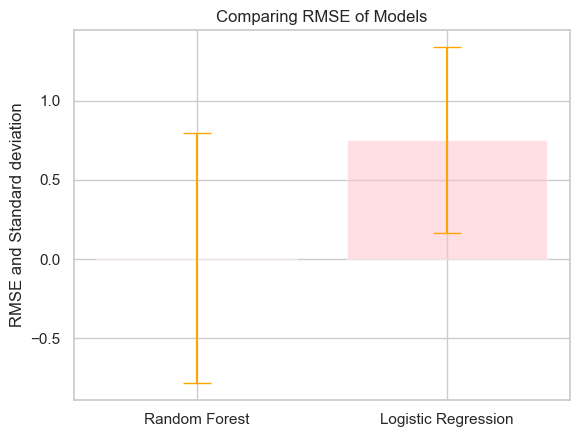

In [74]:
# Data for the bar plot
rmse    = [rf_rmse, logreg_rmse]
std     = [rf_std, logreg_std]
models  = ['Random Forest','Logistic Regression']

# Ensure that rmse_C and std_C have the same length as models
rmse    = rmse[:len(models)]
std     = std[:len(models)]

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(models, rmse, yerr=std, align='center', alpha=0.5, color='pink', ecolor='orange', capsize=10)
ax.set_ylabel('RMSE and Standard deviation')
plt.title('Comparing RMSE of Models')
plt.show()

#### Cross Validating Random Forest Model

In [75]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Create the random forest regressor model
rf_model     = RandomForestRegressor()

# Perform cross-validation
cv_scores    = cross_val_score(rf_model, X, y, cv=5, scoring='r2')

# Print the R-squared scores for each fold
for fold, score in enumerate(cv_scores, 1):
    print(f"Fold {fold}: R-squared score = {score:.4f}")

# Calculate the average R-squared score across all folds
avg_r2_score = cv_scores.mean()
print("Average R-squared score:", avg_r2_score)

Fold 1: R-squared score = 1.0000
Fold 2: R-squared score = 1.0000
Fold 3: R-squared score = 0.9887
Fold 4: R-squared score = 1.0000
Fold 5: R-squared score = 1.0000
Average R-squared score: 0.9977406938775509


In [76]:
# Initiate the model
lasso      = Lasso()

dependent_variable   = 'Cluster'

predictors = data_clusters.columns.tolist()

# Train and fit the models
lasso.fit (train_data[predictors], train_data[dependent_variable])

# Make predictions using test data
lasso_predictions    = lasso.predict(test_data[predictors])

In [77]:
# Calculate RMSE, initially calculate MSE and then take the root
lasso_mse      = mean_squared_error(test_data[dependent_variable],lasso_predictions)
lasso_rmse     = np.sqrt(lasso_mse)

# Calculate the standard deviation of the whole thing
y_pred_numeric = y_pred.astype(float)

lasso_std      = np.std(lasso_predictions)
 
#Output
print("RMSE for Lasso Model:", lasso_rmse)
print("R-Squared for Lasso:",r2_score(test_data[dependent_variable], lasso_predictions))

RMSE for Lasso Model: 0.6202210328616846
R-Squared for Lasso: 0.38285637002134265
